# Libraries

In [297]:
import pandas as pd
import numpy as np
import os
import matplotlib.image as mpimg
import seaborn as sns

# Plotting Libs
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree
from xgboost import plot_importance
import shap

# Statistical Libs
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import warnings

# Collinearity / Feature Selection Libs 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import Binarizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import zero_one_loss
from sklearn.decomposition import PCA

# Model Libs
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from xgboost import XGBClassifier


# Accuracy Libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import learning_curve

# Resampling Libs
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler



# Load Data

In [298]:
df0 = pd.read_pickle(r".\df_multivar\df0_multivar.pkl")
df1 = pd.read_pickle(r".\df_multivar\df1_multivar.pkl")
df2 = pd.read_pickle(r".\df_multivar\df2_multivar.pkl")
df3 = pd.read_pickle(r".\df_multivar\df3_multivar.pkl")
df4 = pd.read_pickle(r".\df_multivar\df4_multivar.pkl")
df5 = pd.read_pickle(r".\df_multivar\df5_multivar.pkl")
df = pd.read_pickle(r".\df_multivar\df_multivar.pkl")


In [299]:
display(df0.shape)
display(df1.shape)
display(df2.shape)
display(df3.shape)
display(df4.shape)
display(df5.shape)
display(df.shape)

(2236, 130)

(26045, 155)

(28409, 155)

(16093, 155)

(12813, 130)

(95731, 155)

(173541, 160)

## Df Input

In [300]:
i = 5
dfi = df5

# Data Preperation

In [301]:
X = dfi.drop("Study_Status_Bin", axis = 1)
y = dfi["Study_Status_Bin"]

# initial X features
X.shape # Check that initial shape of dfi was not changed.

(95731, 154)

# Accuracy tests/ Roc Function


In [302]:
def accuracy(dfi, i, model, X_test, y_test, y_pred, title):
    print(f"Model : Phase {i} - {title}")
    
    print("\na).\nAccuracy Score : (True P + True N) / N total :")
    print(f"{accuracy_score(y_test, y_pred) * 100:.2f}%")

    print("\nb).\nClassification Report :")
    print(classification_report(y_test, y_pred))

    print("\nc).\nPlots :")
    fig , ax = plt.subplots(figsize = (20, 6), nrows = 1, ncols = 2)
    ConfusionMatrixDisplay.from_predictions(y_test , y_pred, ax = ax[0]);
    RocCurveDisplay.from_estimator(model, X_test, y_test, pos_label = 1, ax = ax[1], name = f'{title}');  # Completed = 0, Terminated = 1

    print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]).round(2)) # Predict Probabilities for accurate ROC Auc
    plt.suptitle(f"Phase {i} - {title}", fontsize = 11, fontweight = 'bold')

    ax[0].set_title("1. Confusion Matrix", fontsize = 10, fontweight = 'bold')
    ax[0].set_xlabel("Predicted Label", fontsize = 10, fontweight = 'bold')
    ax[0].set_ylabel("True Label", fontsize = 10, fontweight = 'bold')
    #ax[0].set_xticklabels(["Terminated", "Completed"], fontsize = 10, fontweight = 'bold')
    #ax[0].set_yticklabels(["Terminated", "Completed"], fontsize = 10, fontweight = 'bold')

    ax[1].set_title("2. ROC Curve" , fontsize = 10, fontweight = 'bold')
    ax[1].set_xlabel("True Positive Rate (Terminated)", fontsize = 10, fontweight = 'bold')
    ax[1].set_ylabel("False Positive Rate (Terminated)", fontsize = 10, fontweight = 'bold')

    plt.show()      
    plt.close(fig)  

# Coefs/Importances Function

In [303]:
def fun_linear_coefs(model, X_tr, name):
    coefs = model.coef_[0]  # assuming binary classification
    return pd.DataFrame({
        "Feature": X_tr.columns,
        "Coefficient": coefs,
        "Model": name
    }).sort_values(by = "Coefficient", ascending = False)

In [304]:
###  Feature Importances Function
def fun_feat_import(model, X_tr, name):
    importances = model.feature_importances_
    return pd.DataFrame({
        "Feature": X_tr.columns,
        "Importance": importances,
        "Model": name
    }).sort_values(by = "Importance", ascending=False).reset_index(drop=True)

# Feature Selection

## Train-Test Split, Scale Data

In [305]:
# Train-Test Split
def fun_train_test_split(X_tts_par, y_tts_par):  # function that also uses y
    X_train, X_test, y_train, y_test = train_test_split(X_tts_par, y_tts_par, test_size = 0.3, stratify = y, random_state = 42)
    return X_train, X_test, y_train, y_test

## VarianceThreshold
* Documentation Notes
- Feature selector that removes all low-variance features.
- Looks only at the features (X), not the desired outputs (y), and can thus be used for unsupervised learning.

In [306]:
def fun_var_thres(X_train_vt_par, X_test_vt_par):

    vt = VarianceThreshold(threshold = 0.01)
    # threshold = 0.01: 
    # Binary variables (0, 1) --> removes variables where one class dominates more than ~99% of the time.
    # Continuous variables --> removes those that barely vary across samples (e.g., nearly constant).
    vt = vt.fit(X_train_vt_par)
    # X_train_vt_array = vt.fit_transform(X_test_vt_par) # Values of X (Array). No naming of X

    X_train_vt = X_train_vt_par.loc[:, vt.get_support()] # .loc[:, get support] -->  gives df, not array that tranform gives
    X_test_vt = X_test_vt_par[X_train_vt.columns]

    return X_train_vt, X_test_vt

## MI 
- Info overlap (nonlinear)
- Mutual information (MI) 1 between two random variables is a non-negative value, which measures the dependency between the variables. 

In [307]:
def fun_mi(X_train_mi_par, X_test_mi_par, y_train_mi_par, threshold):

    mi_scores = mutual_info_classif(X_train_mi_par, y_train_mi_par, random_state = 42)
    mi = pd.Series(mi_scores, index = X_train_mi_par.columns)
    kept_cols = mi[mi > threshold].index

    if len(kept_cols) == 0: # If threshold is too strict and drops everything, keep the best one to avoid empty matrix
        kept_cols = [mi.idxmax()] 

    X_train_mi = X_train_mi_par.loc[:, kept_cols].copy() 
    X_test_mi = X_test_mi_par.loc[:, kept_cols].copy()
    
    return X_train_mi, X_test_mi

## VIF --> good for multicoll sensitive models (QDA, LDA) 
** Documentation notes
- Variance inflation factor is a measure for the increase of the variance of the parameter estimates if an additional variable is added to the linear regression. 
- It is a measure for multicollinearity.
- One recommendation is that if VIF is > 5, then the explanatory variable is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.
- For linear collinearity only.


* Warning: Not an error --> warning that vif found an inf.
* A col almost linear associated with other cols. (high multicollinearity).
* The feature is too constant. (Same across categories)
* There are similar (almost same columns/copy_cols)

In [308]:
# VIF --> good for multicoll sensitive models (QDA, LDA) Function

def fun_vif(X_train, X_test, thresh=10.0):
    X_train = X_train.astype(float)
    X_test = X_test.astype(float)

    vif_df = pd.DataFrame({
        "Features": X_train.columns,
        "VIF": [variance_inflation_factor(X_train.values, i)
                for i in range(X_train.shape[1])]
    })

    keep = vif_df.loc[vif_df["VIF"] <= thresh, "Features"]
    return X_train[keep], X_test[keep]


## Resample 
- Datasets are imbalanced towards the positive class. (i.e. COMPLETED = 1)
- Resample train set only, so model will be correctly trained (not biased towards the most common category of Study_Status_Bin).
    --> Avoids information leaking to test set. test set always similar to true cases.
- Performance evaluated on unsampled test set, with real data percentages per category.
 

In [309]:
def fun_resample(X_train_res_par, y_train_res_par): # function that also uses y # Always resample after dataset split

    res = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_train_res, y_train_res = res.fit_resample(X_train_res_par, y_train_res_par) 
    return X_train_res, y_train_res


## Scaling

In [310]:
# Scale continuous/log variables
def fun_scale(X_train_sc_par, X_test_sc_par):  # Scaling always after dataset split

    X_train_sc = X_train_sc_par.copy()
    X_test_sc = X_test_sc_par.copy()

    cont_cols = [col for col in X_train_sc.columns 
                    if (('count' in col.lower() or 'log' in col.lower()) and
                        not any(x in col.lower() for x in ['bin', 'categ', 'list']))]
    if cont_cols:
        scaler = StandardScaler(with_mean = False, with_std = True)

        X_train_sc[cont_cols] = pd.DataFrame(scaler.fit_transform(X_train_sc[cont_cols]),
            columns = cont_cols, index=X_train_sc.index)

        X_test_sc[cont_cols] = pd.DataFrame(scaler.transform(X_test_sc[cont_cols]),
            columns = cont_cols, index=X_test_sc.index)
    else:
        print("No continuous/log columns to scale.")

    return X_train_sc, X_test_sc


## Lasso (L1 Regularization)
- Feature selection + regularization 
- SOS: LASSO assumes a linear relationship between predictors and target (e.g regression model). --> SOS no meaning before non linear models (e.g kernel svc, distance knn etc.) 
- Biased in presence of high correlation 

- C = 1/λ (Inverse of regularization strength) 
- λ > 0 float. 
- Stronger regularization --> smaller coefs.

- Small C = 1/λ = big λ (e.g. 0.001) --> Strong regularization   --> More bias, smaller coefficients (simpler model)
- Large C = 1/λ = small λ = (e.g. 1000)  --> Weak regularization     --> Model fits more to data (can overfit)
- C = 1 = λ = 1, (Default) --> Moderate regularization --> Balanced by default

In [311]:
def fun_lasso(X_train_la_par, X_test_la_par, y_train_la_par):    # lasso surely after dataset split (model built in method)
        
    log_cv = LogisticRegressionCV(
    Cs = 10,   # 10 C values (inverse regularization strength C = 1/λ --> (0.001 to 10)
    cv = 5,                            
    penalty = 'l1',                    
    solver = 'saga',                   
    scoring = 'accuracy',             
    max_iter = 3000,
    random_state = 42,
    class_weight = 'balanced',
    tol = 1e-3)

    log_cv.fit(X_train_la_par, y_train_la_par)
# infinite scores exclusion
    coefs = log_cv.coef_.flatten()
    mask_finite = np.isfinite(coefs)
    fixed_coefs = np.where(mask_finite, coefs, 0).reshape(1, -1)
    log_cv.coef_ = fixed_coefs

    selector = SelectFromModel(log_cv, prefit = True, threshold = 'mean')  # prefit = True --> model already fitted. Choose from its coefs.
    # 1e-5 keep all vars except those too close/equal to 0 coef
    # 1e-5, 'mean' give same accuracy scores in models. But 'mean' is much faster!
    # 'mean' --> removes collinearity error from qda
    X_Kept_la = X_train_la_par.columns[selector.get_support()] # Get a mask, or integer index, of the features selected.

    X_train_la = pd.DataFrame(selector.transform(X_train_la_par), 
                              columns = X_Kept_la, index = X_train_la_par.index) # train data already fitted through log_cv above.
    X_test_la = pd.DataFrame(selector.transform(X_test_la_par), 
                             columns = X_Kept_la, index = X_test_la_par.index)
    
    return X_train_la, X_test_la


## PCA
- Only after scale

In [312]:
def fun_pca(X_train_pca_par, X_test_pca_par, pca_components = None):
    pca = PCA(n_components = pca_components)
    X_train_pca = pca.fit_transform(X_train_pca_par)
    X_test_pca = pca.transform(X_test_pca_par)

    return X_train_pca, X_test_pca

# Data Preparation

## Train - Test Split

In [313]:
# X,y 
X = dfi.drop("Study_Status_Bin", axis = 1)
y = dfi["Study_Status_Bin"]

# Initial number of features 
display(X.shape[1])

# Train-Test Split / Resample / Scale -- Apply to all models
X_train_tts, X_test_tts, y_train_tts, y_test_tss = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)
X_test_res, y_train_res = fun_resample(X_train_tts, y_train_tts)
X_train_sc, X_test_sc = fun_scale(X_test_res, X_test_tts)

X_train = X_train_sc.copy()
X_test = X_test_sc.copy()
y_train = y_train_res.copy()
y_test = y_test_tss.copy()

display(X_train.shape, X_test.shape)

154

(13874, 154)

(28720, 154)

##  Penalties

In [314]:
# VIF
X_train_vif, X_test_vif = fun_vif(X_train, X_test, thresh=10.0)
X_train_vif.shape[1]

C:\Users\Eugenia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


138

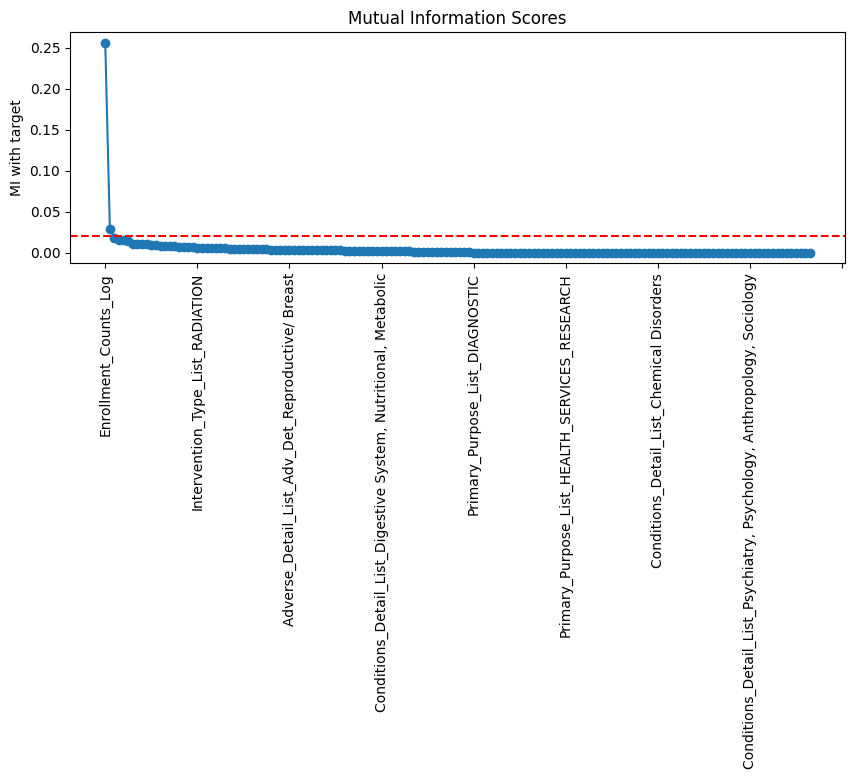

89

In [315]:
# MI -- Wasn't used
X_train_mi, X_test_mi = fun_mi(X_train, X_test, y_train, threshold = 0)

mi_scores = mutual_info_classif(X_train, y_train, random_state = 42)
mi_series = pd.Series(mi_scores, index = X_train.columns).sort_values(ascending=False)

plt.figure(figsize = (10, 3))
mi_series.plot(marker = 'o')
plt.axhline(0.02, color = 'red', linestyle = '--')  # example threshold
plt.title("Mutual Information Scores")
plt.ylabel("MI with target")
plt.xticks(rotation = 90)
plt.show()

display(X_train_mi.shape[1])


In [316]:
# Lasso
X_train_la, X_test_la = fun_lasso(X_train, X_test, y_train)
X_train_la.shape[1]

C:\Users\Eugenia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Eugenia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


54

# Models

## A) Classic Classification

In [317]:
X_train_log = X_train_la.copy()
X_test_log = X_test_la.copy()
y_train_log = y_train.copy()
y_test_log = y_test.copy()

display(X_train_log.shape[1])

54

Model : Phase 5 - Lasso Logistic Regression (L1)

a).
Accuracy Score : (True P + True N) / N total :
83.42%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     25747
           1       0.36      0.79      0.50      2973

    accuracy                           0.83     28720
   macro avg       0.67      0.81      0.70     28720
weighted avg       0.91      0.83      0.86     28720


c).
Plots :
0.89


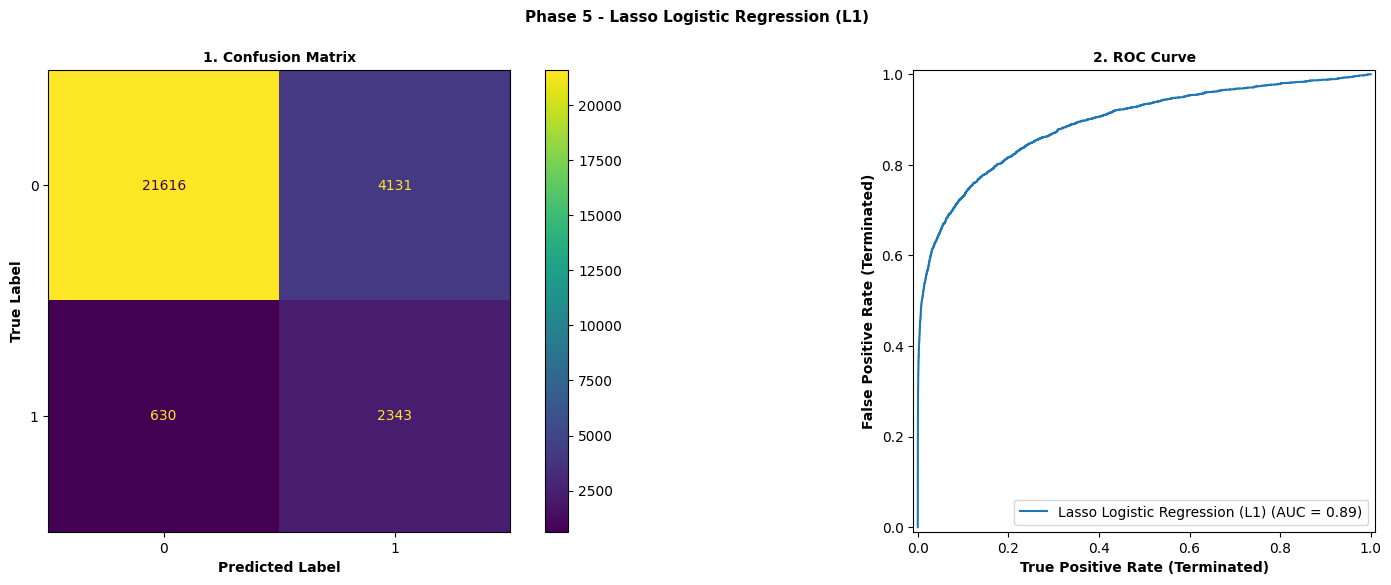

In [318]:
# Model
log_reg = LogisticRegression(max_iter = 5000 , solver = 'saga', class_weight = 'balanced',  random_state = 42)  
# Final Model
log_model = log_reg.fit(X_train_log, y_train_log)
# y_pred
y_pred_log_l1 = log_model.predict(X_test_log)
# Accuracy Score
accuracy(dfi, i, log_model, X_test_log, y_test_log, y_pred_log_l1, "Lasso Logistic Regression (L1)")


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_27272\4129836578.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_log_sam, plot_size = (10, 5), show = False)


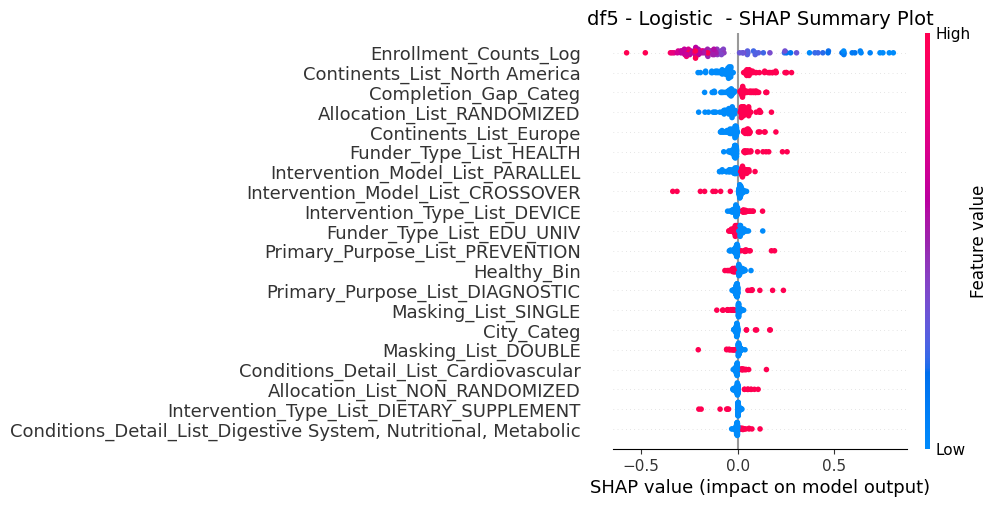

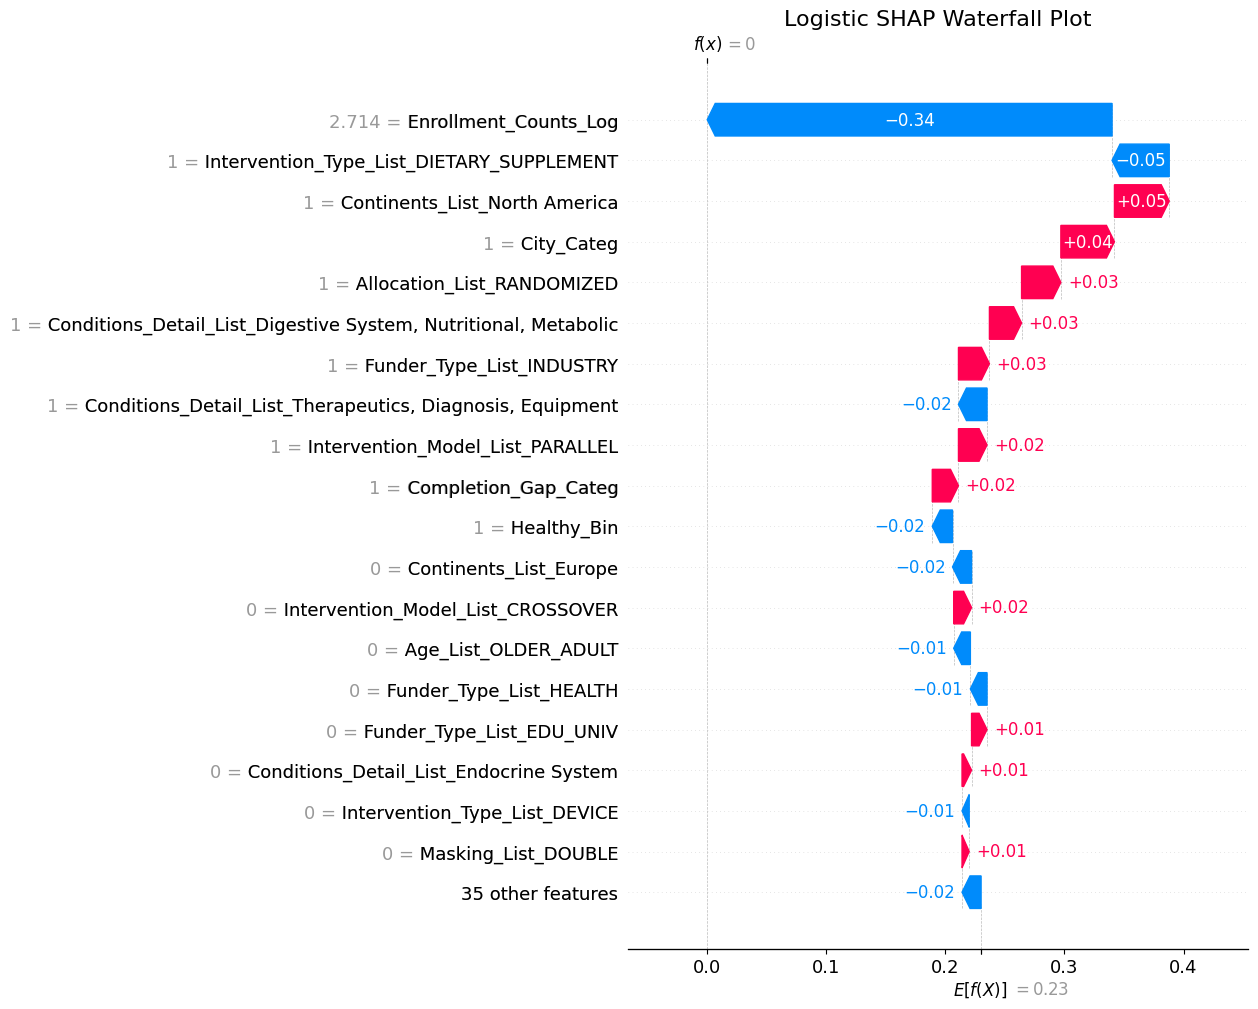

In [319]:
# Impact on the prediction (how much a feature contributes to pushing the prediction left (negative) or right (positive)).
# Blue = low feature value.
# Red = high feature value.
# Example: Enrollment_Counts_Log:
# High values (red) → strong negative SHAP values → push prediction to Completed.
# Low values (blue) → positive SHAP values → push toward Terminated.
# SHAP X-axis shows how much each feature pushes the prediction toward class 0 or 1, in log-odds space. (value -5)

# SHAP dataset overview
X_test_log_sam = shap.sample(X_test_log, 100)
explainer = shap.Explainer(log_model.predict, X_test_log_sam)
shap_values = explainer(X_test_log_sam)

# Summary Plot --> overall 
model = 'log_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

shap.summary_plot(shap_values, X_test_log_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Logistic  - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Waterfall Plot --> 1 data point prediction
shap.waterfall_plot(shap_values[0], max_display = 20, show = False) 
plt.title("Logistic SHAP Waterfall Plot", fontsize = 16) 
plt.show()


### LDA - Linear Discriminant Analysis

- QDA and LDA assume Gaussian distributions.

In [320]:
# Same as log above
X_train_lda = X_train_log.copy()
X_test_lda = X_test_log.copy()
y_train_lda = y_train.copy()
y_test_lda = y_test.copy()

display(X_train_lda.shape[1])


54

Best Parameters : {'n_components': 1, 'shrinkage': 0.001}
Best Estimator : LinearDiscriminantAnalysis(n_components=1, shrinkage=0.001, solver='lsqr',
                           store_covariance=True)
Model : Phase 5 - Linear Discriminant Analysis (LDA)

a).
Accuracy Score : (True P + True N) / N total :
84.45%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     25747
           1       0.38      0.78      0.51      2973

    accuracy                           0.84     28720
   macro avg       0.67      0.81      0.71     28720
weighted avg       0.91      0.84      0.87     28720


c).
Plots :
0.89


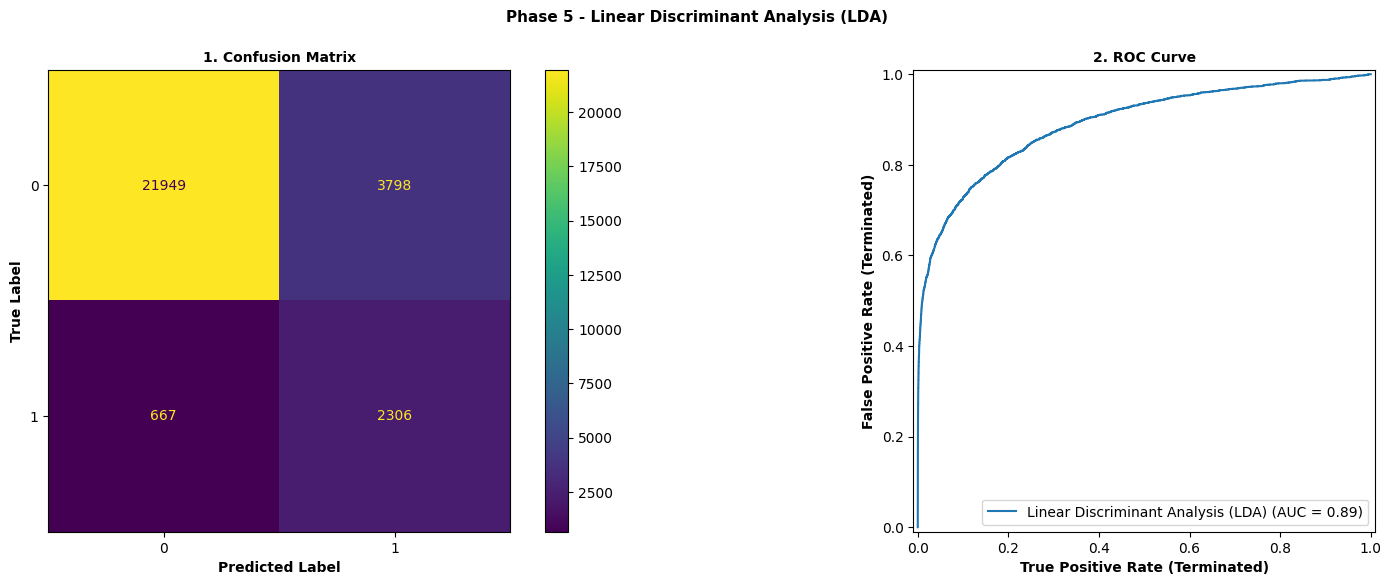

In [321]:
# Model
lda = LDA(store_covariance = True, solver = 'lsqr') # Use solver = lsqr if cv needed.

# Grid Search CV
param_grid = {
    "shrinkage" : [None, "auto"] + list(np.linspace(0.001, 1, 10)), 
    'n_components' : np.arange(1, min(X_train_lda.shape[1], len(np.unique(y_train)) - 1) + 1)
    } 
lda_grid = GridSearchCV(lda, param_grid = param_grid, cv = 5, n_jobs = -1) # cv = 5 default

# Final Model
lda_model = lda_grid.fit(X_train_lda, y_train_lda) # automatically gives the best.estimator
print(f'Best Parameters : {lda_model.best_params_}')
print(f'Best Estimator : {lda_model.best_estimator_}')

# y_pred
y_pred_lda = lda_model.predict(X_test_lda)

# Accuracy Score
accuracy(dfi, i, lda_model, X_test_lda, y_test_lda, y_pred_lda, "Linear Discriminant Analysis (LDA)")


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_27272\1429119517.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_lda_sam, plot_size = (10, 5), show = False)


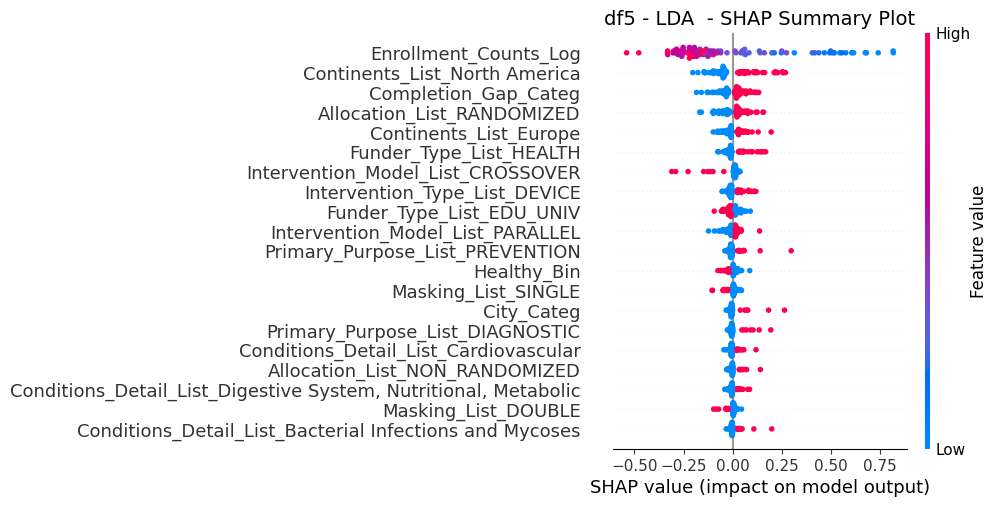

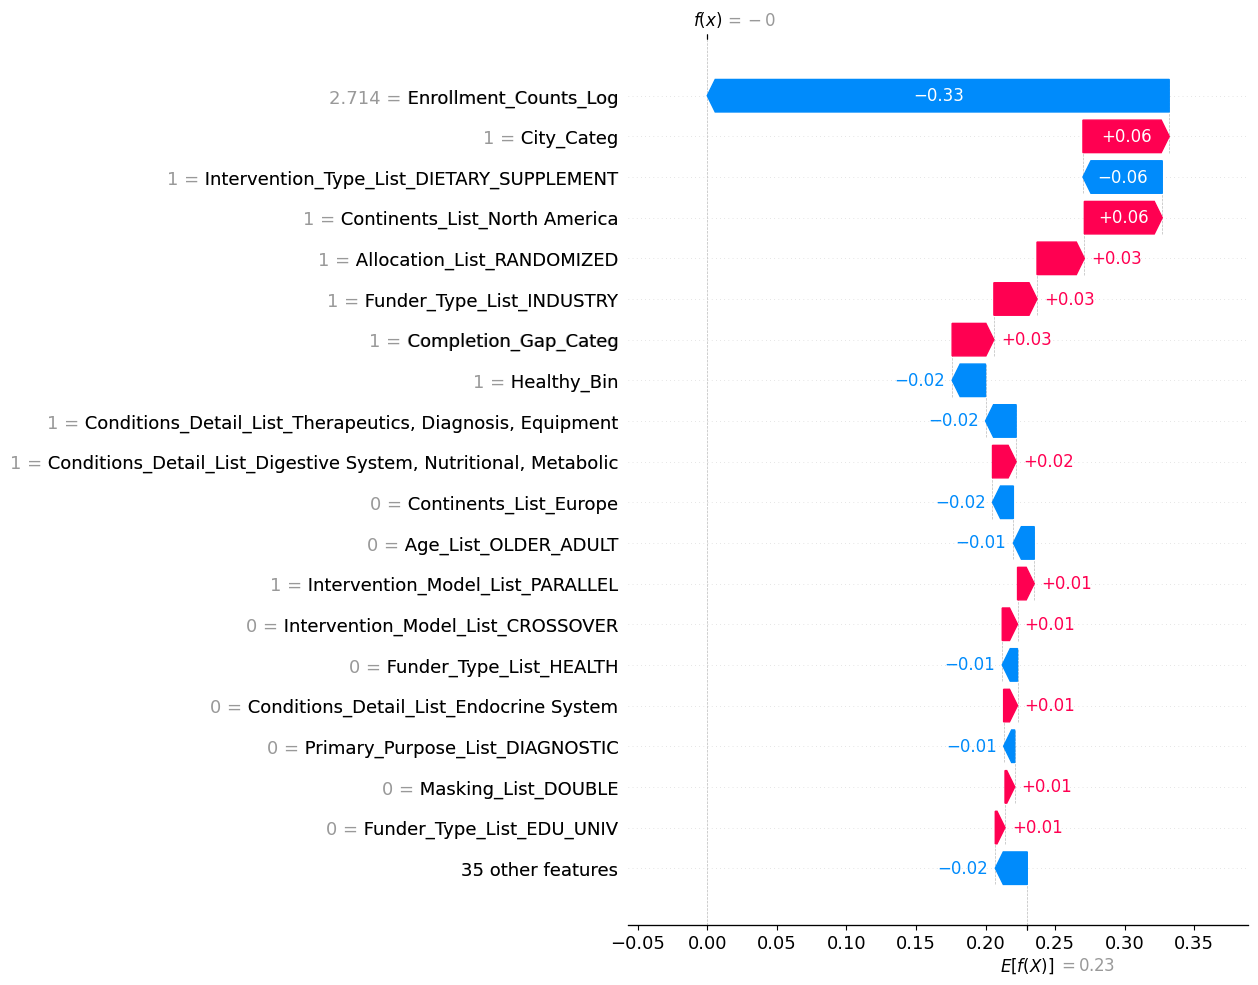

In [322]:
# SHAP
X_test_lda_sam = shap.sample(X_test_lda, 100)
explainer = shap.Explainer(lda_model.best_estimator_.predict, X_test_lda_sam)
shap_values = explainer(X_test_lda_sam)

# Save plot
model = 'lda_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_lda_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - LDA  - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)


### QDA - Quantratic Discriminant Analysis
- QDA very sensistive to collinear data!
QDA and LDA assume Gaussian distributions.

In [323]:
# QDA does not assume linear relation X - y --> lasso assumes. 
# However lasso before QDA gives better results. (in auc and also accuracy)

X_train_qda = X_train_la.copy()
X_test_qda = X_test_la.copy()
y_train_qda = y_train.copy()
y_test_qda = y_test.copy()

display(X_train_qda.shape[1])

54

"Best Parameters : {'reg_param': 0.20689655172413793}"

'Best Estimator : QuadraticDiscriminantAnalysis(reg_param=0.20689655172413793,\n                              store_covariance=True)'

Model : Phase 5 - Quantric Discriminant Analysis (QDA)

a).
Accuracy Score : (True P + True N) / N total :
82.38%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     25747
           1       0.35      0.78      0.48      2973

    accuracy                           0.82     28720
   macro avg       0.66      0.81      0.69     28720
weighted avg       0.91      0.82      0.85     28720


c).
Plots :
0.89


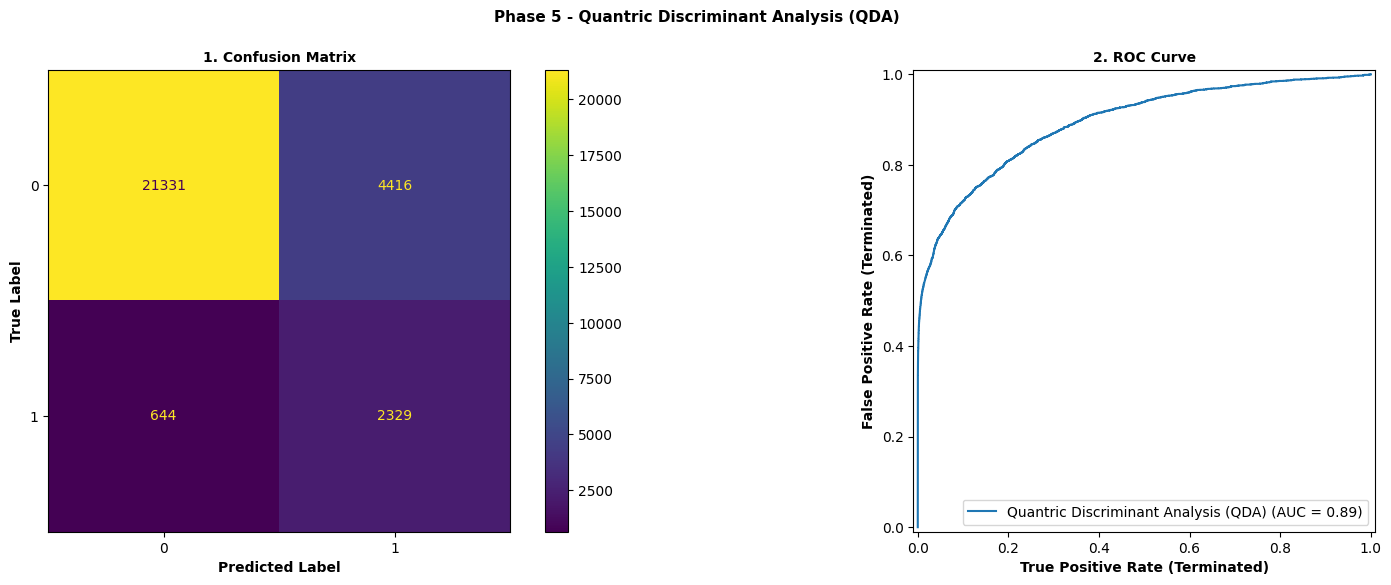

In [324]:
# Model
qda = QDA(store_covariance = True)

# GridSearch
param_grid = {
    "reg_param": np.linspace(0, 1, 30)
    }
qda_grid = GridSearchCV(qda, param_grid = param_grid, cv = 5, n_jobs = -1) # cv = 5 default

# Final model
qda_model = qda_grid.fit(X_train_qda, y_train_qda)
display(f'Best Parameters : {qda_model.best_params_}')
display(f'Best Estimator : {qda_model.best_estimator_}')

# y_pred
y_pred_qda = qda_model.predict(X_test_qda)

# Accuracy Score
accuracy(dfi, i, qda_model, X_test_qda, y_test_qda, y_pred_qda, "Quantric Discriminant Analysis (QDA)")

C:\Users\Eugenia\AppData\Local\Temp\ipykernel_27272\1307359302.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_qda_sam, plot_size = (10, 5), show = False)


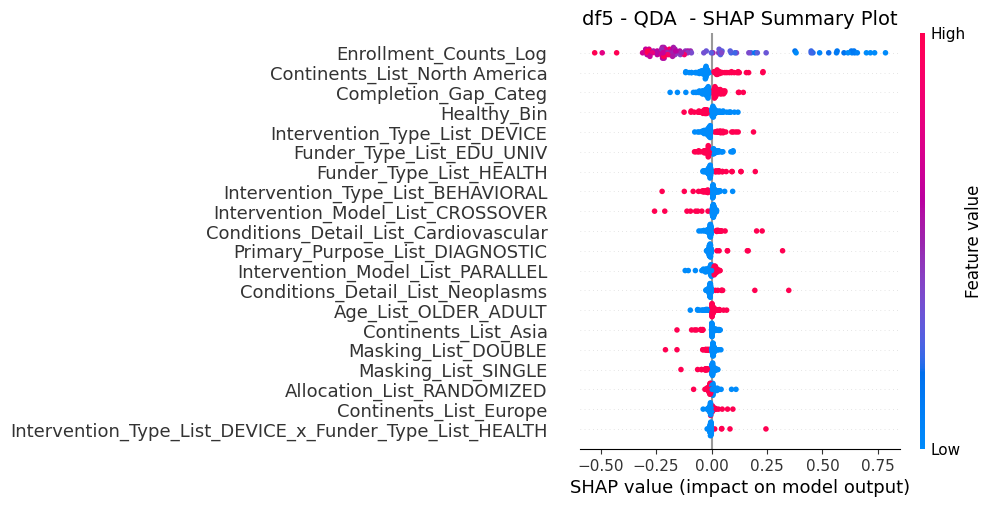

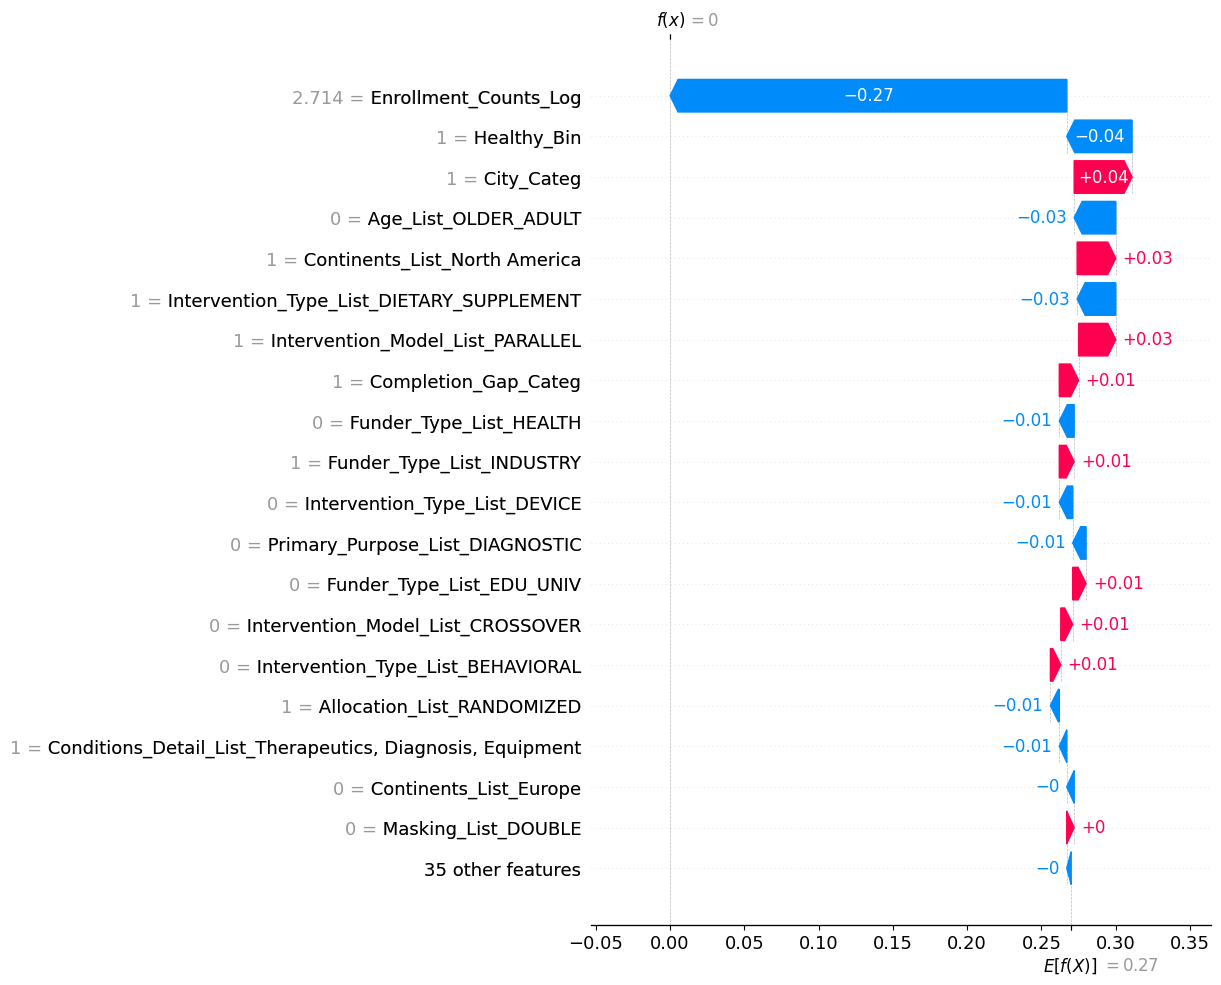

In [325]:
# SHAP
X_test_qda_sam = shap.sample(X_test_qda, 100)
explainer = shap.Explainer(qda_model.best_estimator_.predict, X_test_qda_sam)
shap_values = explainer(X_test_qda_sam)

# Save plot
model = 'qda_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_qda_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - QDA  - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Elastic Net Logistic Regression
- l1_ratio l1 / l2 = Elastic Net
- l1_ratio = 1 = Lasso (l1)
- l1_ratio = 0 = Ridge (l2) 
- 0 < l1_ratio < 1 

In [326]:
X_train_el = X_train.copy() 
X_test_el = X_test.copy()
y_train_el = y_train.copy()
y_test_el = y_test.copy()

display(X_train_el.shape[1])


154

"Best Parameters : {'l1_ratio': 0.8}"

"Best Estimator : LogisticRegression(l1_ratio=0.8, max_iter=3000, penalty='elasticnet',\n                   random_state=42, solver='saga')"

Model : Phase 5 - Elastic Net Logistic Regression

a).
Accuracy Score : (True P + True N) / N total :
83.42%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     25747
           1       0.36      0.79      0.50      2973

    accuracy                           0.83     28720
   macro avg       0.67      0.81      0.70     28720
weighted avg       0.91      0.83      0.86     28720


c).
Plots :
0.89


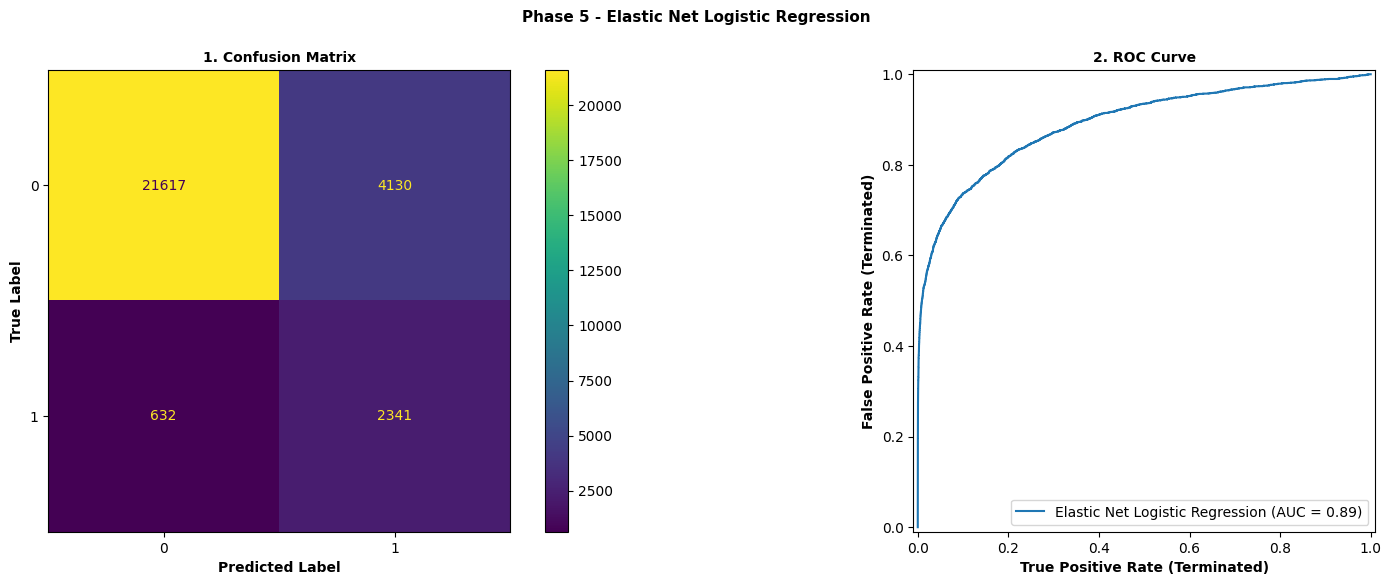

In [327]:
# Model (4+min df5)
log_el = LogisticRegression(penalty = 'elasticnet', max_iter = 3000, solver = "saga", random_state = 42)   

# Grid Search
param_grid = {
    "l1_ratio" : np.linspace(0.1, 1, 10, endpoint = True)
    } 
log_el_grid = GridSearchCV(log_el, param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
el_model = log_el_grid.fit(X_train_el, y_train_el)  
display(f'Best Parameters : {el_model.best_params_}')
display(f'Best Estimator : {el_model.best_estimator_}')

# y_pred
y_pred_el = el_model.predict(X_test_el)

# Accuracy Score
accuracy(dfi, i, el_model, X_test_el, y_test_el, y_pred_el, "Elastic Net Logistic Regression")


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_27272\2177796025.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_el_sam, plot_size = (10, 5), show = False)


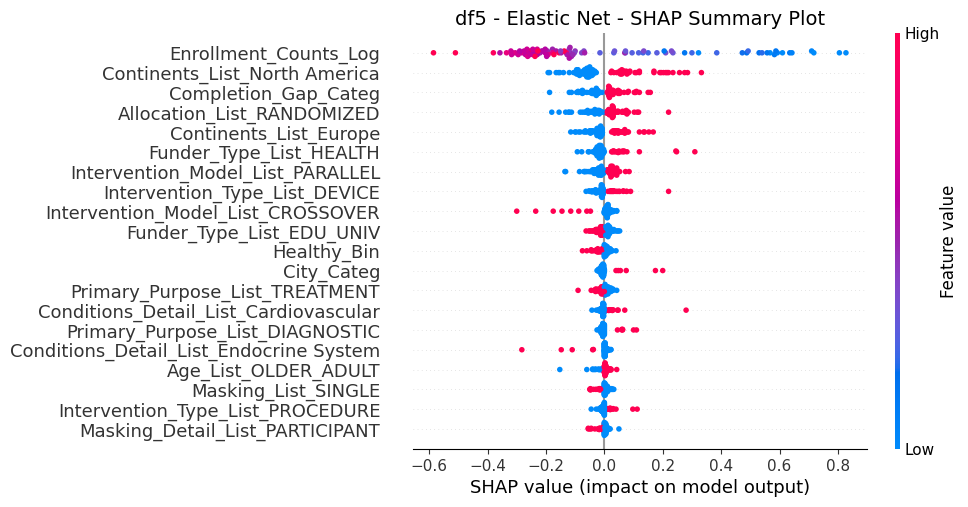

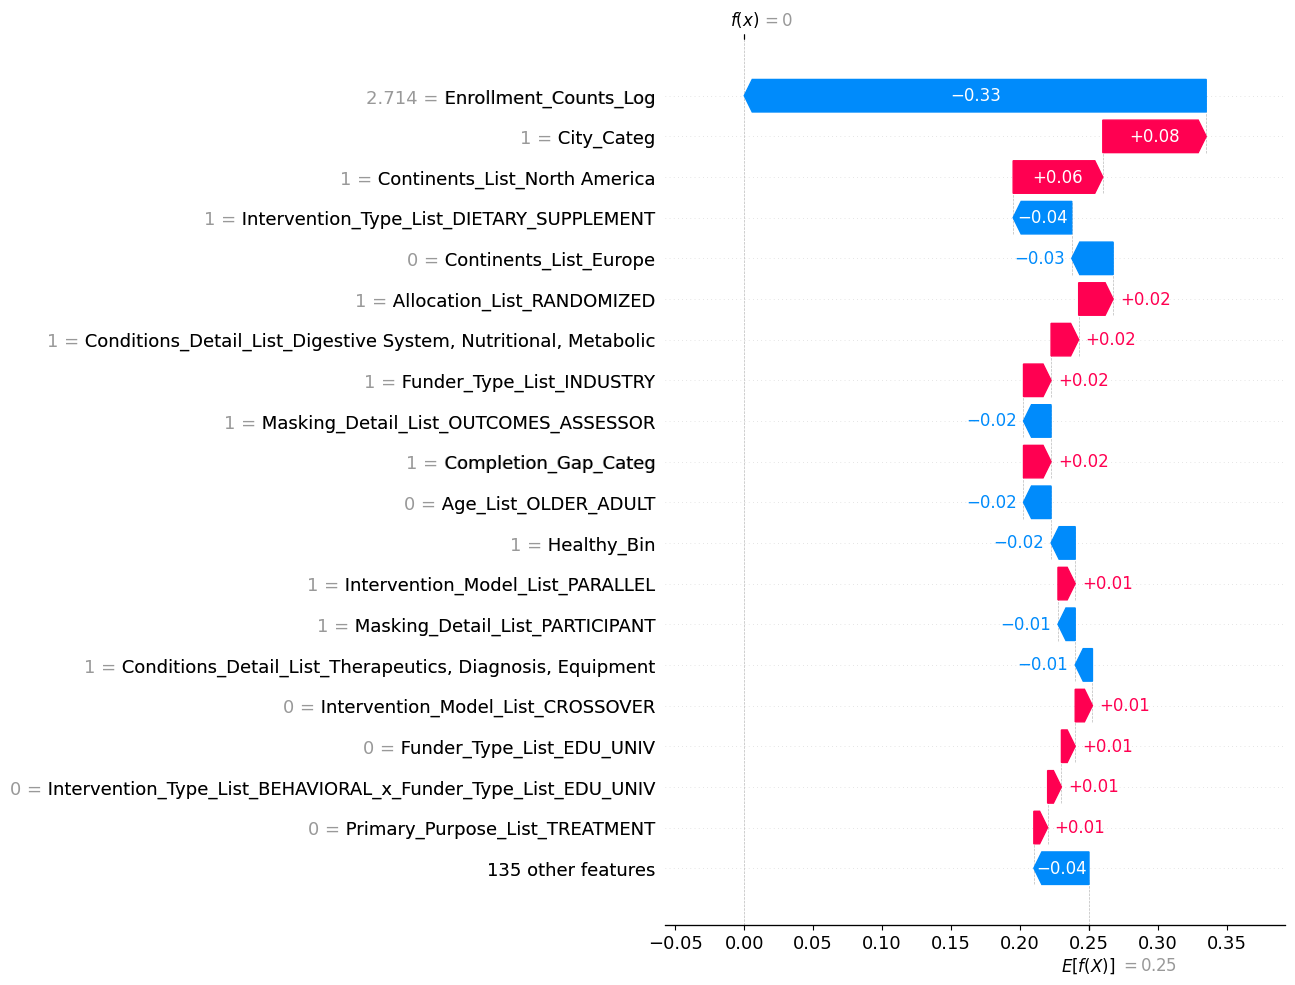

In [328]:
# SHAP
X_test_el_sam = shap.sample(X_test_el, 100)
explainer = shap.Explainer(el_model.best_estimator_.predict, X_test_el_sam)
shap_values = explainer(X_test_el_sam)

# Save plot
model = 'el_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_el_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Elastic Net - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

## B) ML Classification

### KNN - K Nearest Neighbors

In [329]:
# KNN --> Dimension reduction did not impact the scores. (Distances matter more than dimension in knn)
X_train_knn = X_train.copy()
X_test_knn = X_test.copy()
y_train_knn = y_train.copy()
y_test_knn = y_test.copy()

display(X_train_knn.shape[1])

154

"Best Parameters : {'n_neighbors': 45}"

'Best Estimator : KNeighborsClassifier(n_neighbors=45)'

Model : Phase 5 - K-Nearest Neighbors Classifier (KNN)

a).
Accuracy Score : (True P + True N) / N total :
83.80%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.85      0.90     25747
           1       0.36      0.75      0.49      2973

    accuracy                           0.84     28720
   macro avg       0.66      0.80      0.70     28720
weighted avg       0.90      0.84      0.86     28720


c).
Plots :
0.88


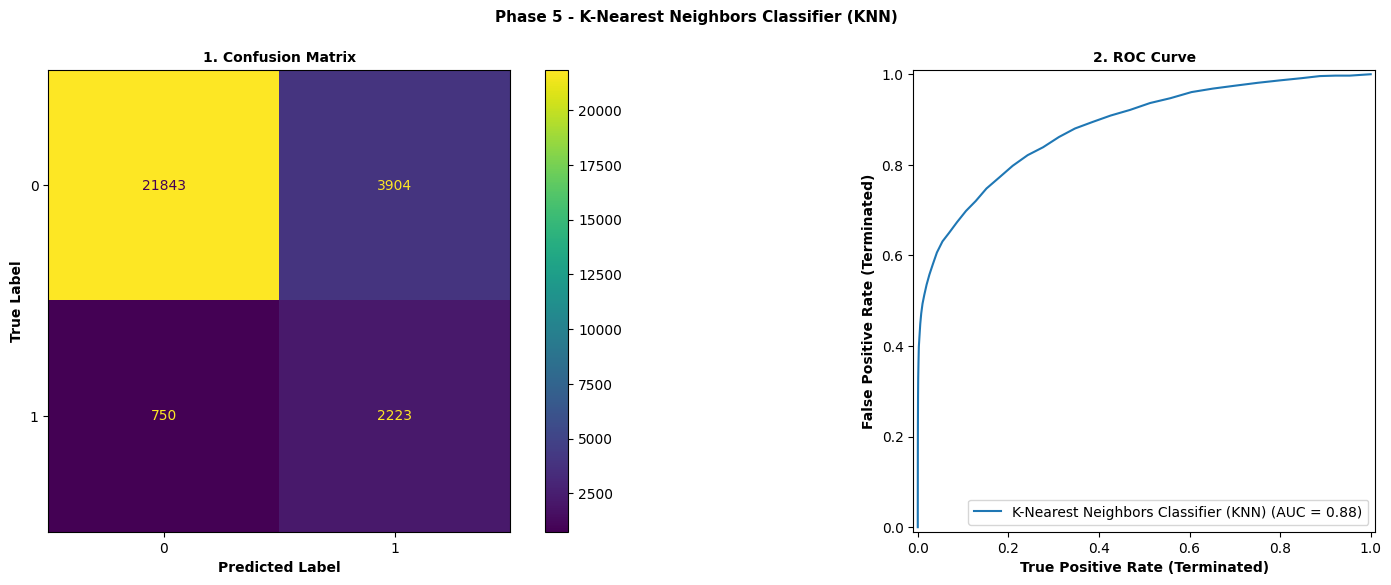

In [330]:
# Model (2+ min)
knn = KNeighborsClassifier()

# Grid Search
param_grid = {"n_neighbors" : np.linspace(1, 100, 50, endpoint = True).astype(int)} 

# CV
knn_grid = GridSearchCV(knn , param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
knn_model = knn_grid.fit(X_train_knn, y_train_knn)
display(f'Best Parameters : {knn_model.best_params_}')
display(f'Best Estimator : {knn_model.best_estimator_}')

# y_pred
y_pred_knn = knn_model.predict(X_test_knn)

# Accuracy Score
accuracy(dfi, i, knn_model, X_test_knn, y_test_knn, y_pred_knn, "K-Nearest Neighbors Classifier (KNN)")


PermutationExplainer explainer: 101it [02:27,  1.58s/it]                         
C:\Users\Eugenia\AppData\Local\Temp\ipykernel_27272\4002721857.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_knn_sam, plot_size = (10, 5), show = False)


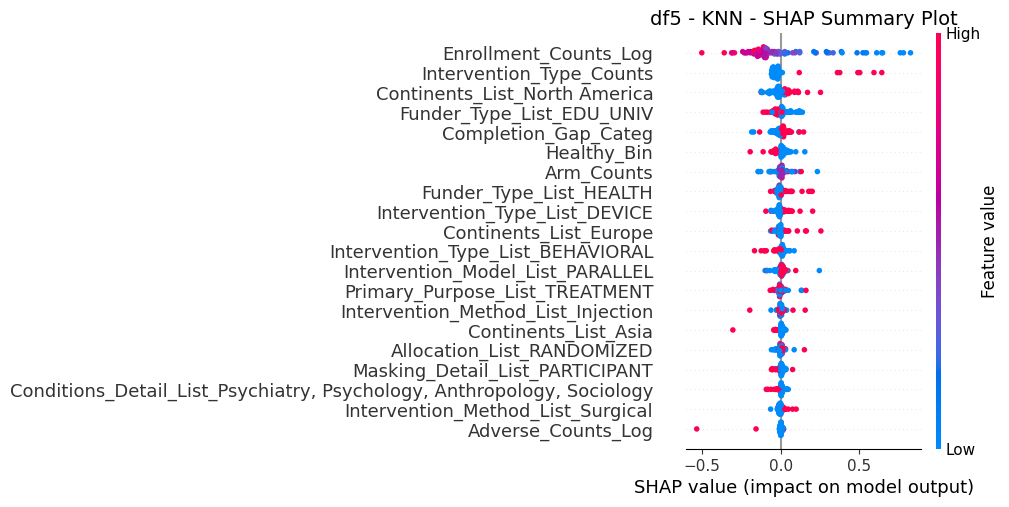

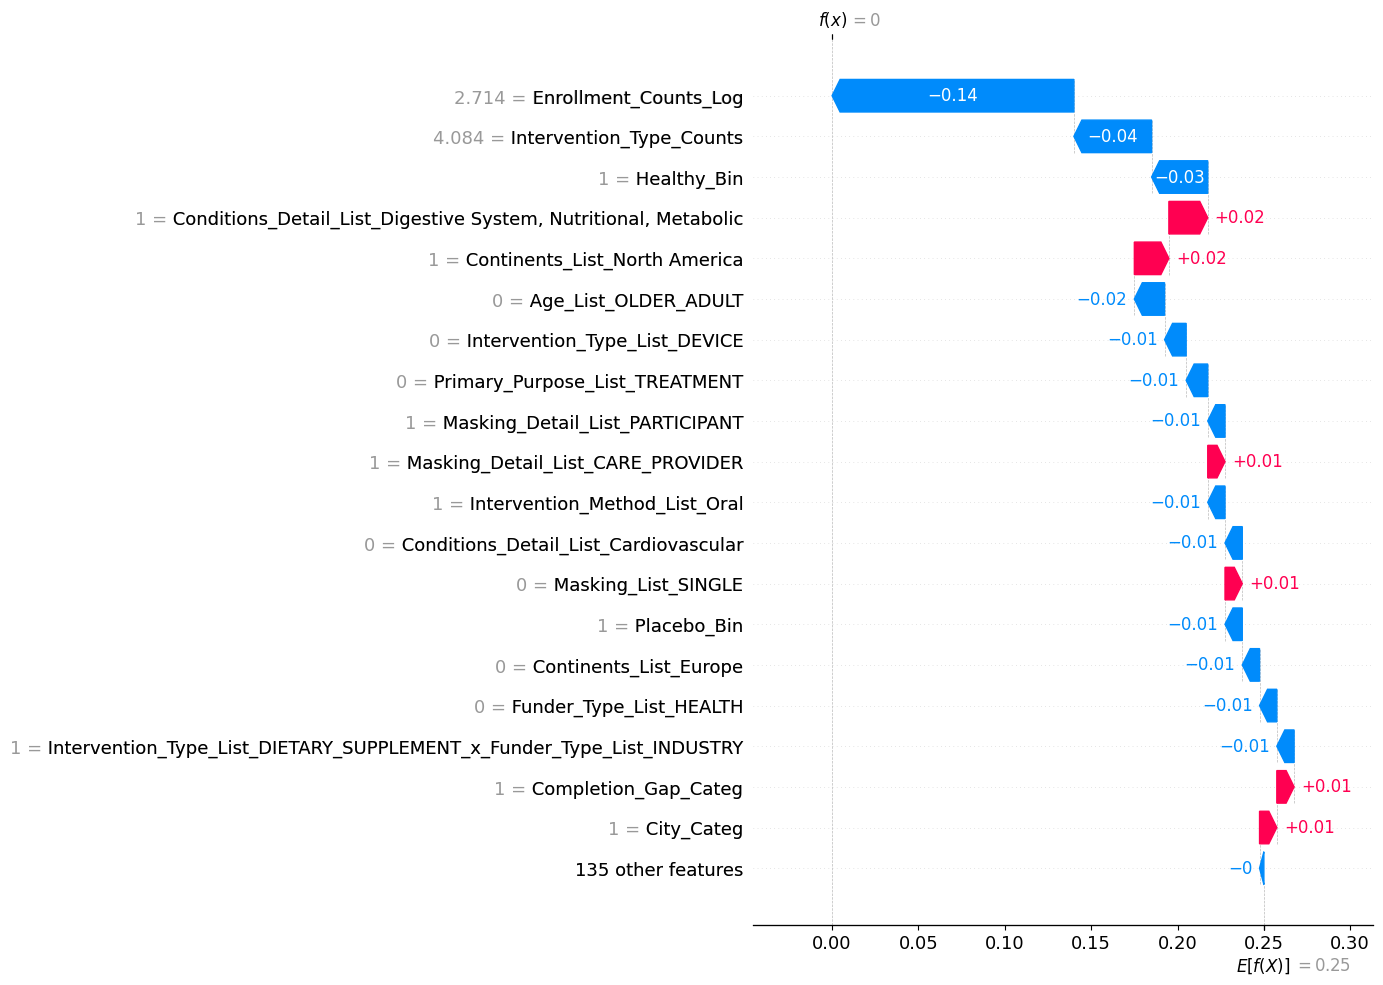

In [331]:
# SHAP
X_test_knn_sam = shap.sample(X_test_knn, 100)  # sample needed for computational efficacy
explainer = shap.Explainer(knn_model.best_estimator_.predict, X_test_knn_sam)
shap_values = explainer(X_test_knn_sam)

# Save plot
model = 'knn_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_knn_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - KNN - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### SVC - Support Vector Classifier
- (31+mins + lasso df)

In [332]:
# SVC --> Dimension reduction did not impact scores (+ impacted a little negative)

X_train_svc = X_train.copy()
X_test_svc = X_test.copy()
y_train_svc = y_train.copy()
y_test_svc = y_test.copy()

display(X_train_svc.shape[1])

154

"Best Parameter kernel: {'degree': 2, 'kernel': 'poly'}"

"Best Estimator: SVC(class_weight='balanced', degree=2, kernel='poly', probability=True,\n    random_state=42)"

Model : Phase 5 - Support Vector Classifier (SVC)

a).
Accuracy Score : (True P + True N) / N total :
86.75%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     25747
           1       0.42      0.76      0.54      2973

    accuracy                           0.87     28720
   macro avg       0.70      0.82      0.73     28720
weighted avg       0.91      0.87      0.88     28720


c).
Plots :
0.9


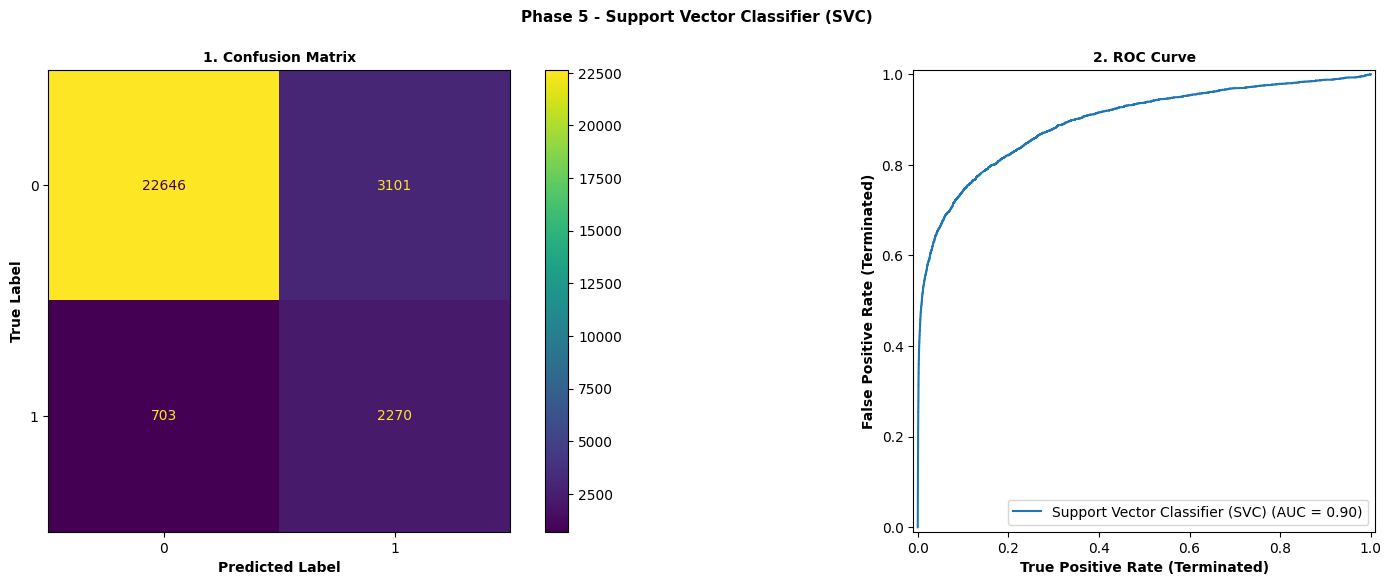

In [333]:
# Model (max = 7.5 mins df5)   
svc = SVC(probability = True, random_state = 42, class_weight = 'balanced')

# Hyperparameters CV
param_grid = [
    {"kernel": ["linear"]},
    {"kernel": ["rbf"]},
    {"kernel": ["sigmoid"]},
    {"kernel": ["poly"], "degree": [2, 3]}  # df --> chooses 'rdf' --> maybe exclude poly cause it runs too slow 31+min.
]

# CV
svc_grid = GridSearchCV(svc, param_grid = param_grid, cv = 4, n_jobs = -1) # 4 cv cause it runs too slow with 5.

# Final Model
svc_model = svc_grid.fit(X_train_svc, y_train_svc)
display(f'Best Parameter kernel: {svc_model.best_params_}')
display(f'Best Estimator: {svc_model.best_estimator_}')

# y_pred
y_pred_svc = svc_model.predict(X_test_svc)

# Accuracy Score
accuracy(dfi, i, svc_model, X_test_svc, y_test_svc, y_pred_svc, "Support Vector Classifier (SVC)")


PermutationExplainer explainer: 31it [00:55,  2.23s/it]                        
C:\Users\Eugenia\AppData\Local\Temp\ipykernel_27272\3536509692.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_svc_sam, plot_size = (10, 5), show = False)


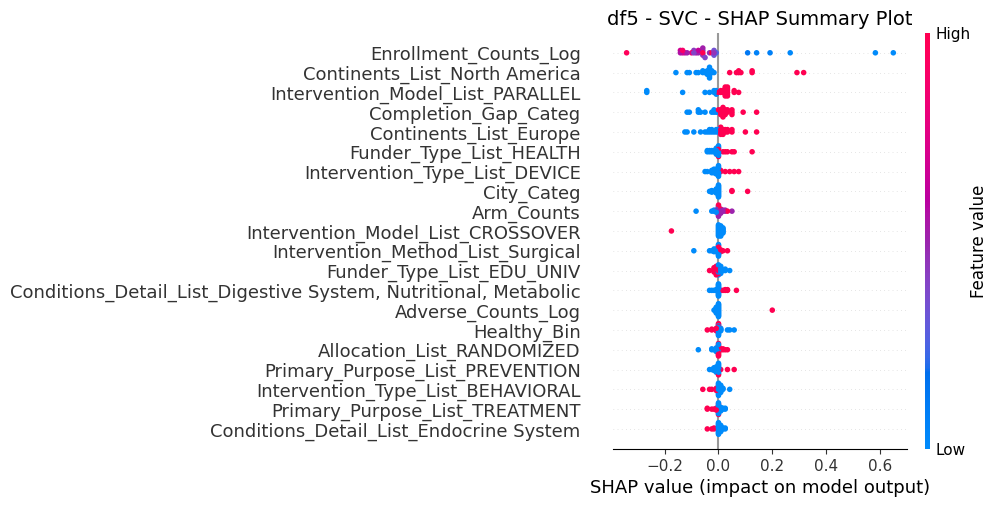

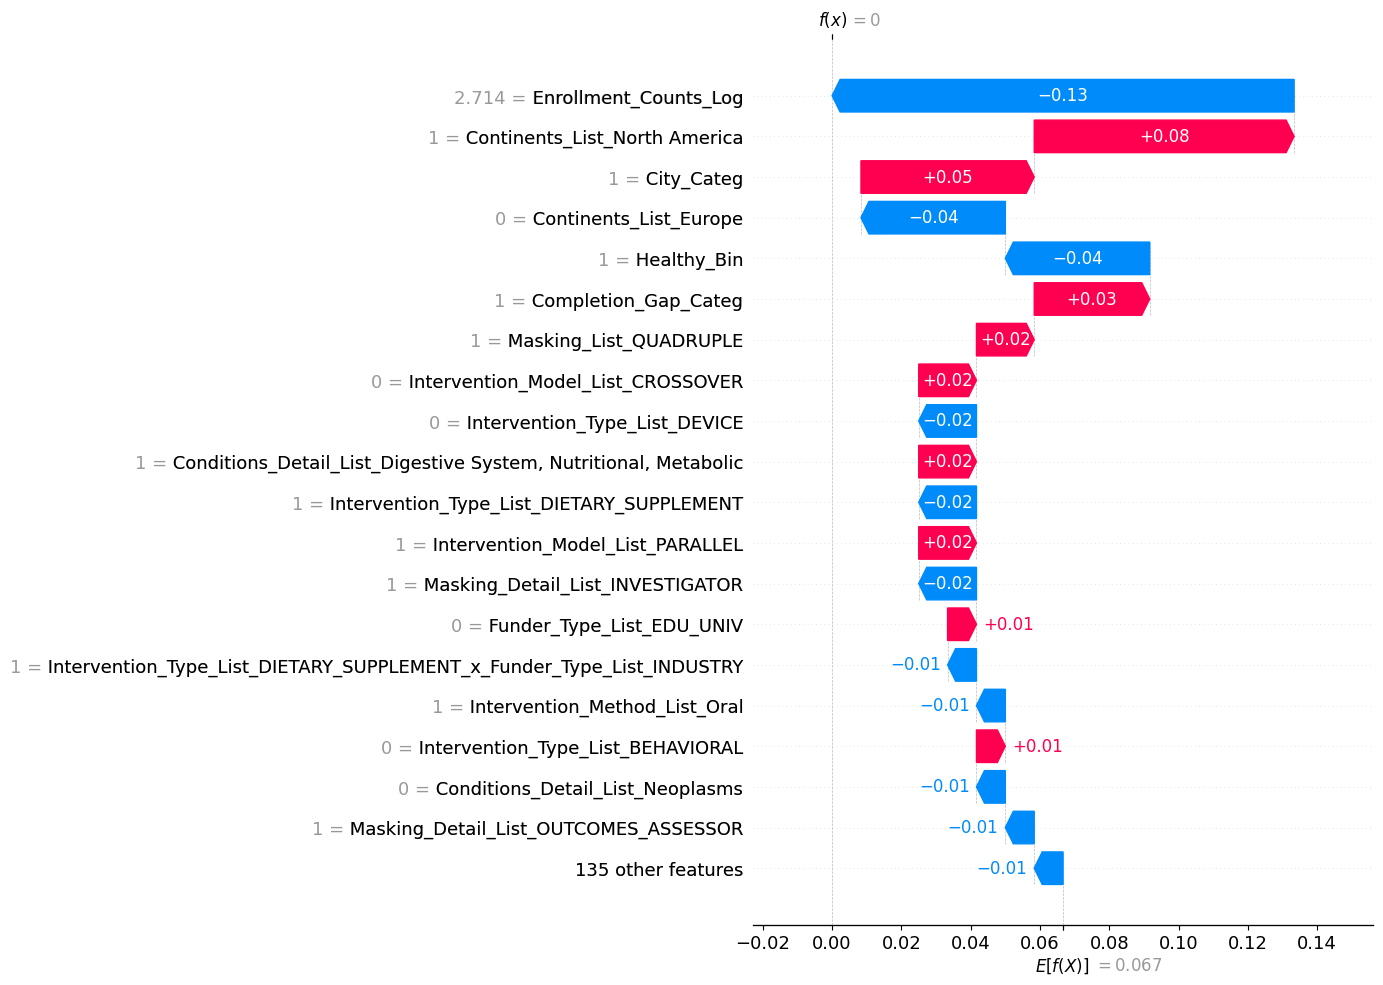

In [334]:
# SHAP (5+ mins maybe)
X_test_svc_sam = shap.sample(X_test_svc, 30)  # 30 cause computationaly too slow 
explainer = shap.Explainer(svc_model.best_estimator_.predict, X_test_svc_sam)
shap_values = explainer(X_test_svc_sam)

# Save plot
model = 'svc_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_svc_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - SVC - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Tree (Pruned)


In [335]:
# Built-in Feature Selective models
X_train_tr = X_train.copy()
X_test_tr = X_test.copy()
y_train_tr = y_train.copy()
y_test_tr = y_test.copy()

display(X_train_tr.shape[1])

154

In [336]:
# cc_alphas values meaningful for dataset
tree = DecisionTreeClassifier(random_state = 42)
path = tree.cost_complexity_pruning_path(X_train_tr, y_train_tr)
ccp_alphas = path.ccp_alphas
display(ccp_alphas.min(), ccp_alphas.mean(), ccp_alphas.max())

0.0

0.00036471068904851006

0.17990201520626586

"Best Parameter criterion/max_depth: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}"

"Best Estimator : DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,\n                       random_state=42)"

Model : Phase 5 - Decision Tree Classifier

a).
Accuracy Score : (True P + True N) / N total :
84.63%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     25747
           1       0.38      0.74      0.50      2973

    accuracy                           0.85     28720
   macro avg       0.67      0.80      0.70     28720
weighted avg       0.90      0.85      0.87     28720


c).
Plots :
0.87


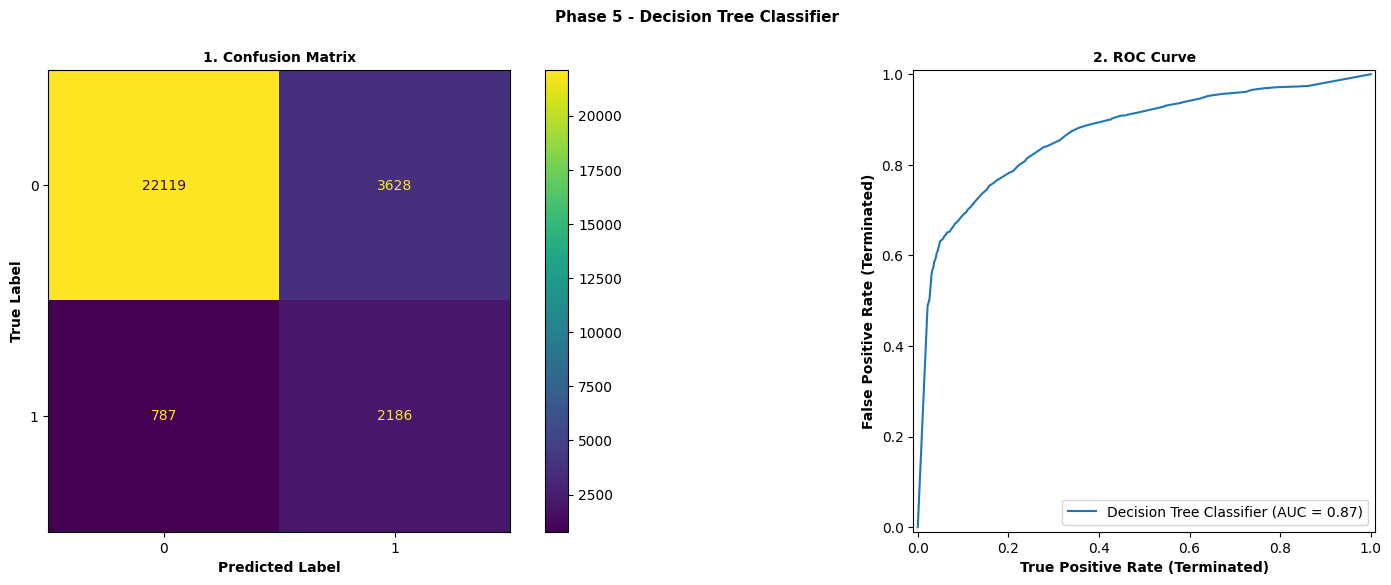

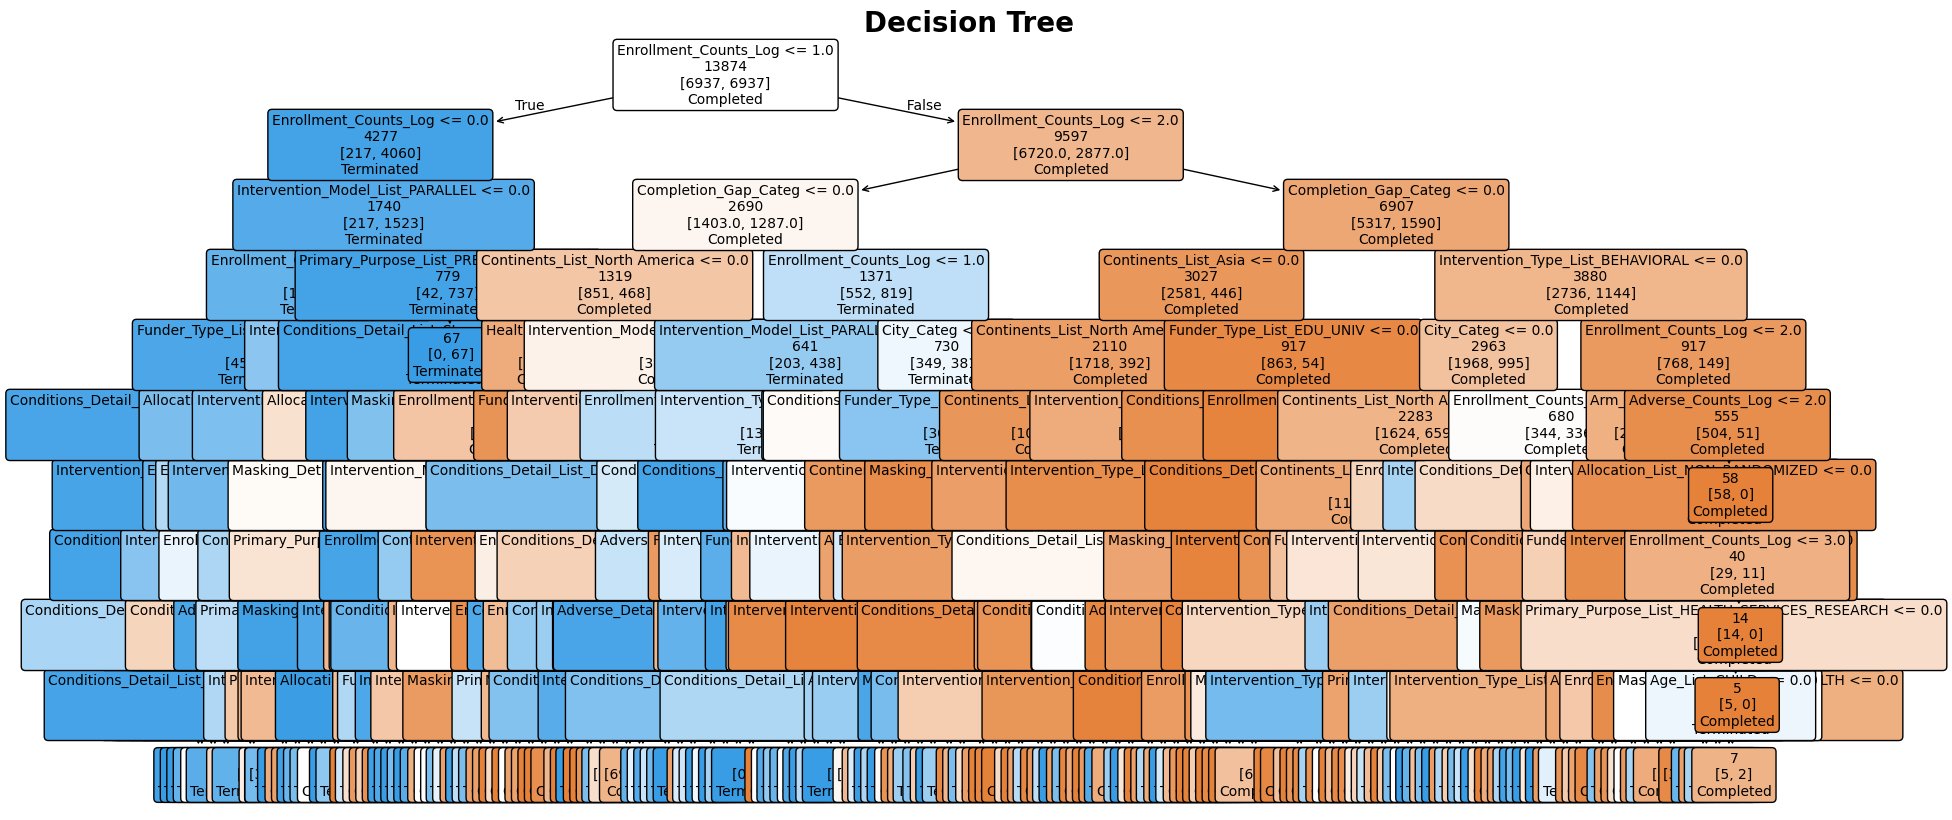

In [ ]:
# Model (3+ mins df5)
tree = DecisionTreeClassifier(random_state = 42)

# Hyperparameters CV
param_grid = {
    'criterion': ['gini', 'entropy'],           # Splitting strategy
    'max_depth': [2, 3, 5, 10, 20, None],       # give small depth as choice # Pre-pruning --> Built in feature Selection
    'min_samples_split': [2, 5, 10],            # Min samples to split a node
    'min_samples_leaf': [1, 2, 4],              # Min samples in a leaf
    'max_features': [None, 'sqrt', 'log2'],     # Max features to consider at each split
    'ccp_alpha': np.linspace(0, np.max(ccp_alphas), 10),   # Post-Pruning --> Cost-complexity parameter
}

# CV
tree_grid = GridSearchCV(tree, param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
tr_model = tree_grid.fit(X_train_tr, y_train_tr)
display(f'Best Parameter criterion/max_depth: {tr_model.best_params_}')
display(f'Best Estimator : {tr_model.best_estimator_}')

# y_pred
y_pred_tr = tr_model.predict(X_test_tr)

# Accuracy Score
accuracy(dfi, i, tr_model, X_test_tr, y_test_tr, y_pred_tr, "Decision Tree Classifier")

# Plot Tree
tree_clf = tr_model.best_estimator_

plt.figure(figsize = (20, 10))
plot_tree(
    tree_clf,
    feature_names = X_train_tr.columns,
    class_names = ['Completed', 'Terminated'],
    max_depth = tr_model.best_params_['max_depth'],
    label = 'none',
    filled = True,
    rounded = True,
    proportion = False,
    impurity = False,
    precision = 0,
    fontsize = 10
)
plt.title("Decision Tree", fontsize = 20, fontweight = 'bold')
plt.show()


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_27272\3219855117.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_tr_sam, plot_size = (10, 5), show = False)


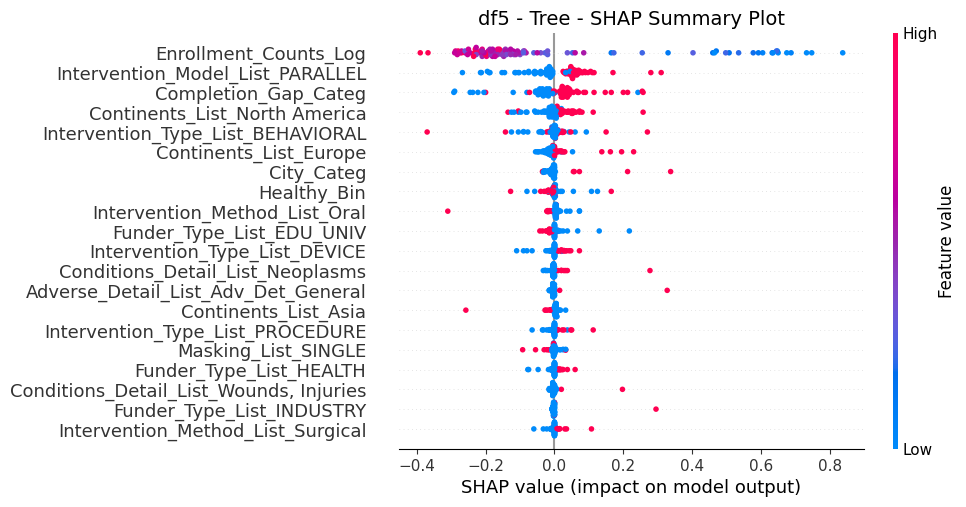

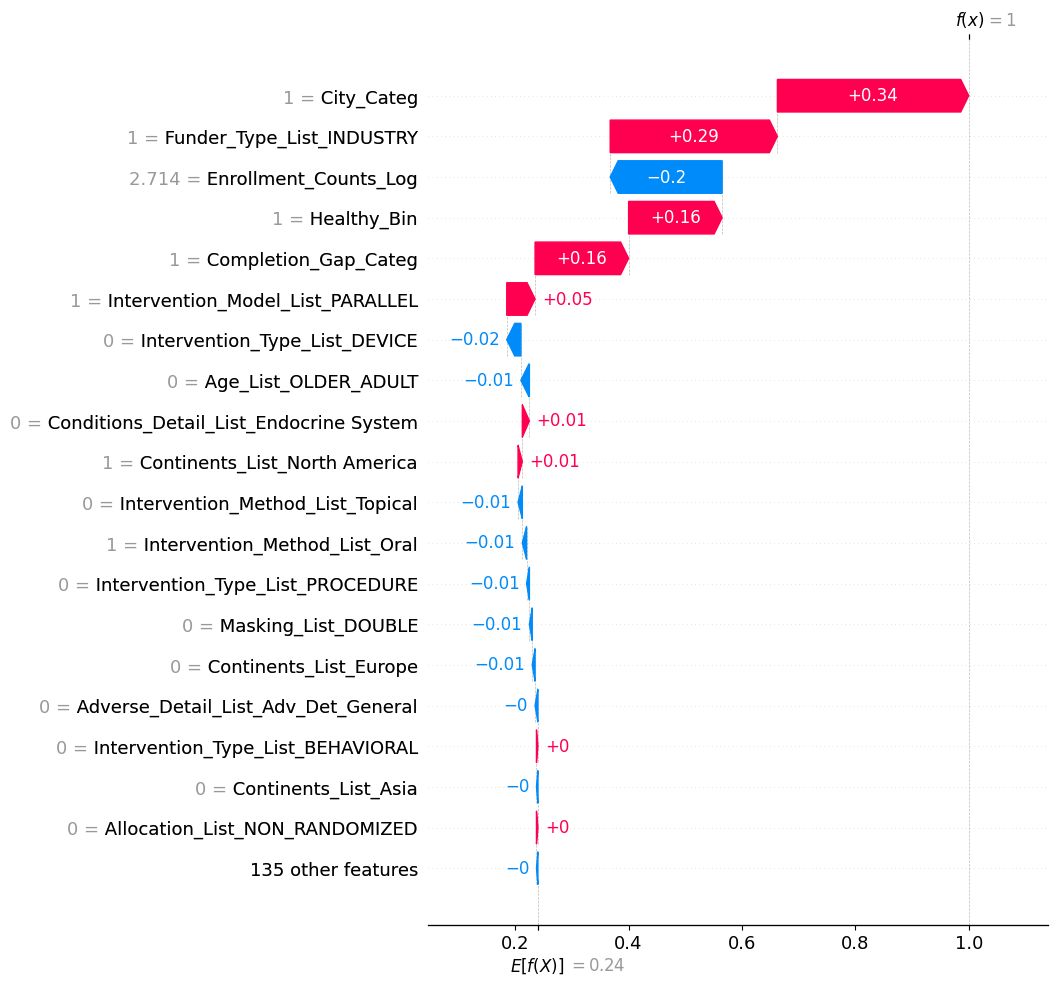

In [338]:
# SHAP
X_test_tr_sam = shap.sample(X_test_tr, 100)
explainer = shap.Explainer(tr_model.best_estimator_.predict, X_test_tr_sam)
shap_values = explainer(X_test_tr_sam)

# Save plot
model = 'tr_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_tr_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Tree - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Random Forest

In [339]:
# Built-in Feature Selective models
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()
y_train_rf = y_train.copy()
y_test_rf = y_test.copy()

display(X_train_rf.shape[1])

154

"Best Parameter criterion/bootstrap/n_estimators : {'bootstrap': True, 'criterion': 'entropy', 'max_features': None}"

"Best Estimator : RandomForestClassifier(criterion='entropy', max_features=None, random_state=42)"

Model : Phase 5 - Random Forest Classifier

a).
Accuracy Score : (True P + True N) / N total :
85.53%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.87      0.91     25747
           1       0.40      0.75      0.52      2973

    accuracy                           0.86     28720
   macro avg       0.68      0.81      0.72     28720
weighted avg       0.91      0.86      0.87     28720


c).
Plots :
0.89


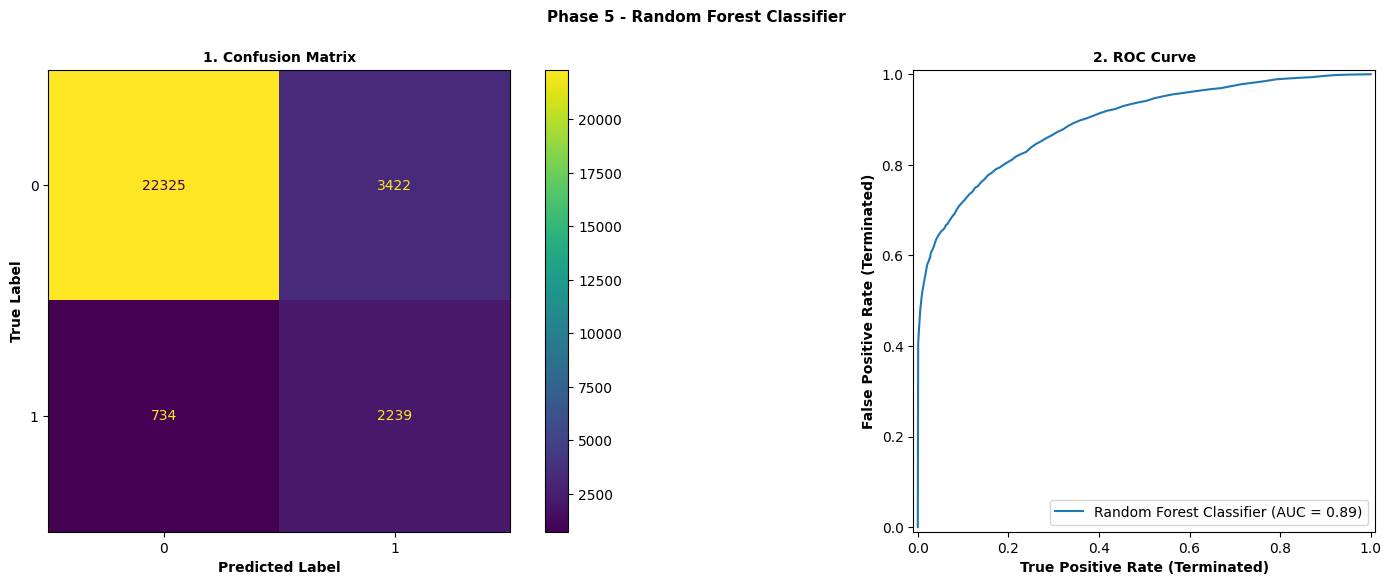

In [340]:
# Model (1+min)
forest = RandomForestClassifier(random_state = 42)

# CV
param_grid = {
    "criterion" : ['gini', 'entropy', 'log_loss'], 
    "bootstrap" : [True, False],  # Bootstrap samples when building trees. If False, the whole dataset is used to build each tree.
    "max_features" : ["sqrt", "log2", None]  # None = m = p = Bagging Random Forest. / sqrt = m = sqrt(p) = Classic Random Forest. / log2 = m = log2(p) = Other Random Forest.
    } 

forest_grid = GridSearchCV(forest , param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
rf_model = forest_grid.fit(X_train_rf, y_train_rf)
display(f'Best Parameter criterion/bootstrap/n_estimators : {rf_model.best_params_}')
display(f'Best Estimator : {rf_model.best_estimator_}')

# y_pred
y_pred_rf = rf_model.predict(X_test_rf)

# Accuracy Score
accuracy(dfi, i, rf_model, X_test_rf, y_test_rf, y_pred_rf, "Random Forest Classifier")


PermutationExplainer explainer: 101it [00:15,  2.28it/s]                         
C:\Users\Eugenia\AppData\Local\Temp\ipykernel_27272\50703949.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_rf_sam, plot_size = (10, 5), show = False)


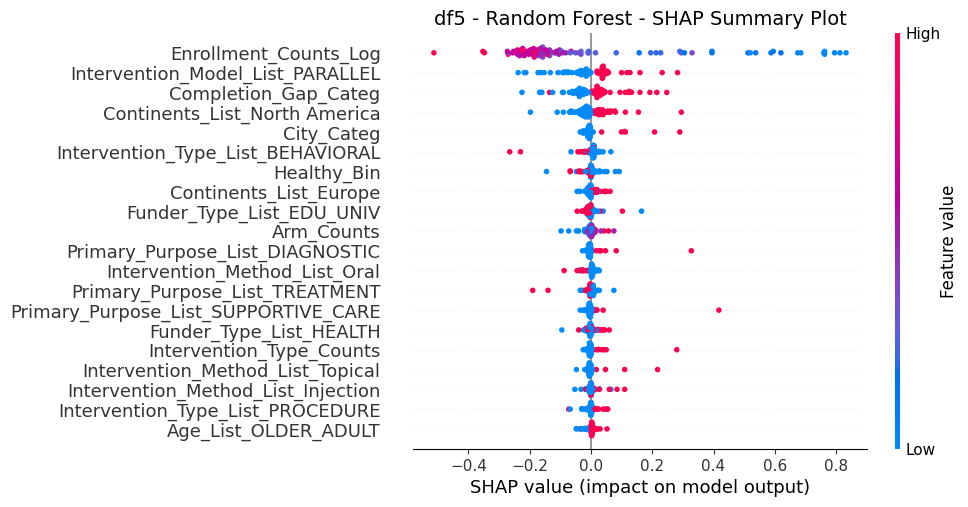

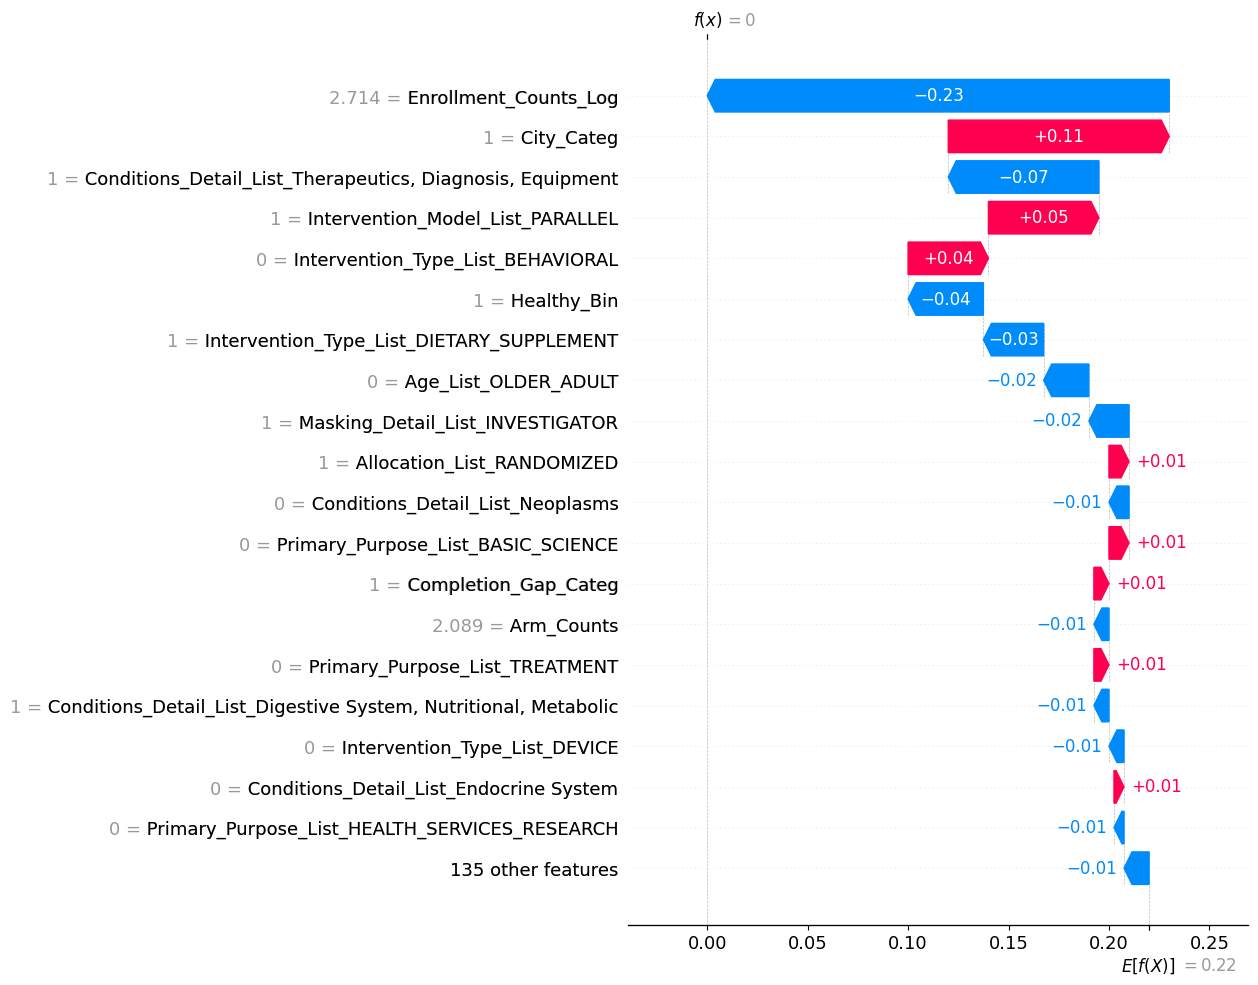

In [341]:
# SHAP
X_test_rf_sam = shap.sample(X_test_rf, 100)
explainer = shap.Explainer(rf_model.best_estimator_.predict, X_test_rf_sam)
shap_values = explainer(X_test_rf_sam)

# Save plot
model = 'rf_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_rf_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Random Forest - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Gradient Boosting Classifier

In [342]:
# Built-in Feature Selective models
X_train_gb = X_train.copy()
X_test_gb = X_test.copy()
y_train_gb = y_train.copy()
y_test_gb = y_test.copy()

display(X_train_gb.shape[1])

154

"Best Parameter learning_rate : {'learning_rate': 0.01}"

'Best Estimator : GradientBoostingClassifier(learning_rate=0.01, random_state=42)'

Model : Phase 5 - Gradient Boosting Classifier

a).
Accuracy Score : (True P + True N) / N total :
90.71%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     25747
           1       0.54      0.67      0.60      2973

    accuracy                           0.91     28720
   macro avg       0.75      0.80      0.77     28720
weighted avg       0.92      0.91      0.91     28720


c).
Plots :
0.88


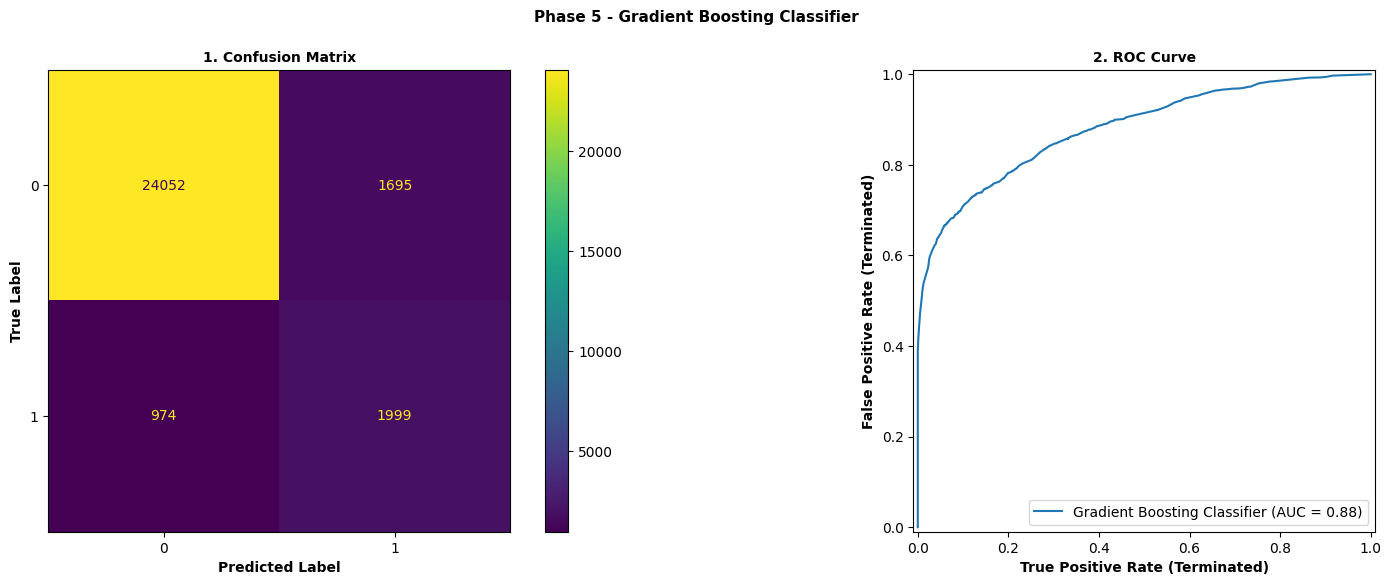

In [343]:
# Model
gra_boost = GradientBoostingClassifier(random_state = 42)  

# CV
param_grid = {
    "learning_rate" : np.linspace(0.01, 10, 10, endpoint = True),
    # n_estimators = np.linspace(1000, 10000, 10, endpoint = True).astype(int) # Number of boosting stages to be run. Default = 100.
    }

gra_boost_grid = GridSearchCV(gra_boost , param_grid = param_grid, cv = 5, n_jobs = -1)

# Final Model
gb_model = gra_boost_grid.fit(X_train_gb, y_train_gb)
display(f'Best Parameter learning_rate : {gb_model.best_params_}')
display(f'Best Estimator : {gb_model.best_estimator_}')

# y_pred
y_pred_gb = gb_model.predict(X_test_gb)

# Accuracy Score
accuracy(dfi, i, gb_model, X_test_gb, y_test_gb, y_pred_gb, "Gradient Boosting Classifier")


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_27272\3688710552.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_gb_sam, plot_size = (10, 5), show = False)


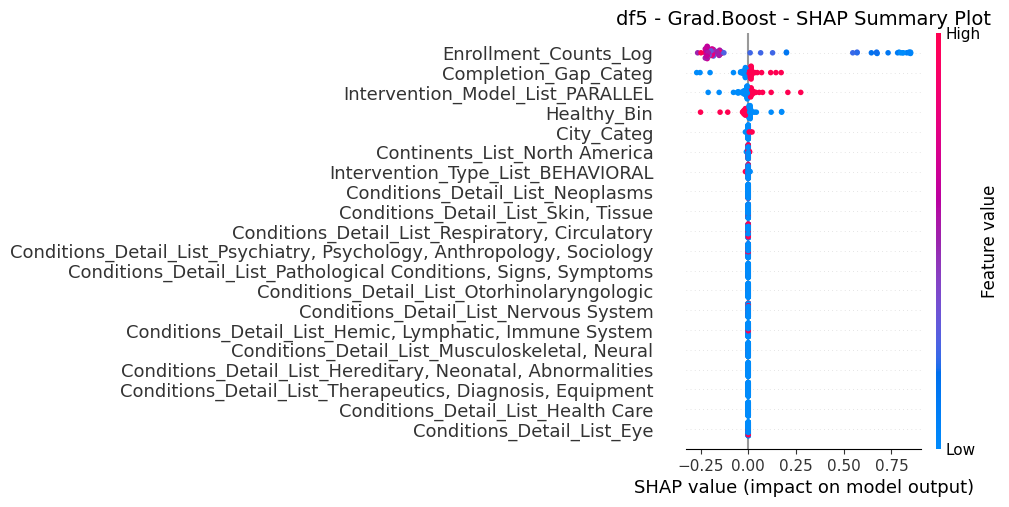

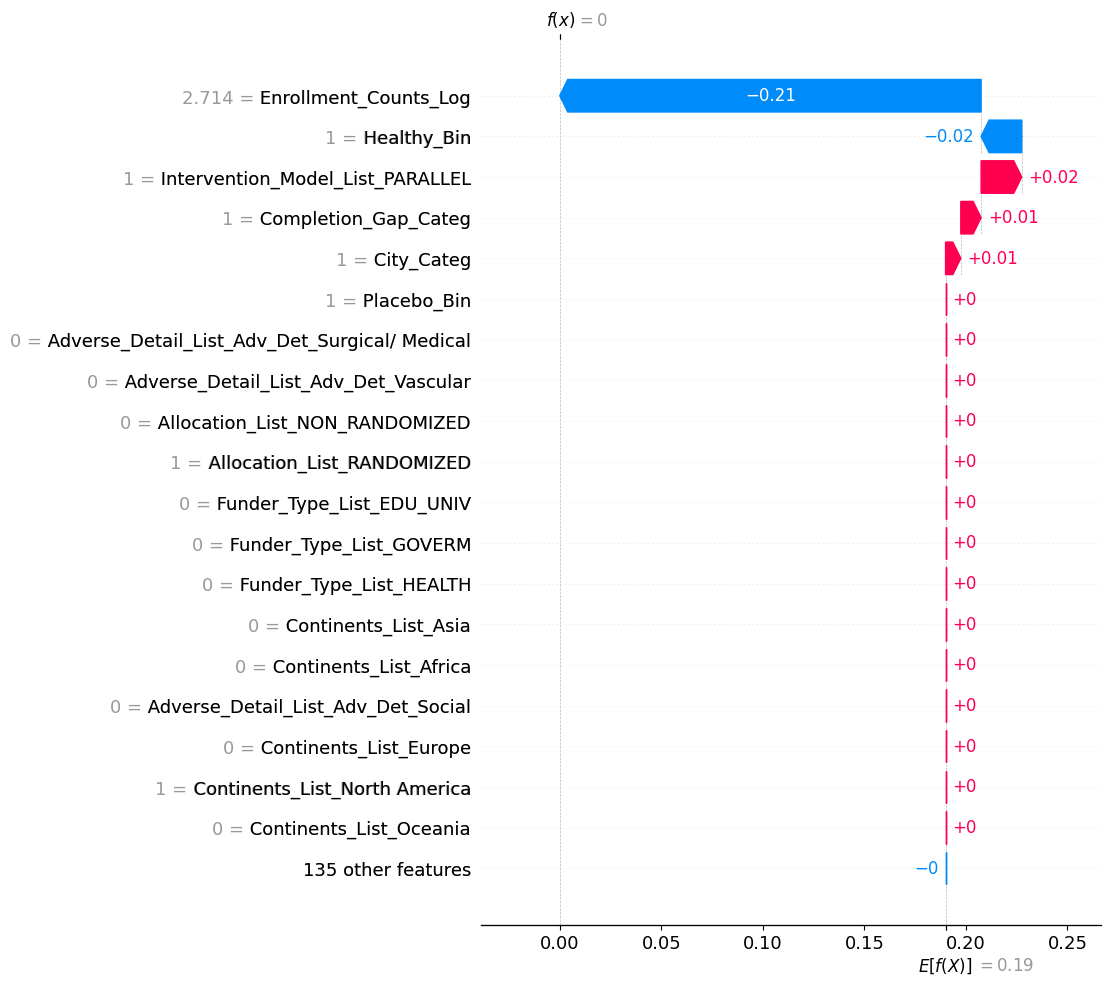

In [344]:
# SHAP
X_test_gb_sam = shap.sample(X_test_gb, 100)
explainer = shap.Explainer(gb_model.best_estimator_.predict, X_test_gb_sam)
shap_values = explainer(X_test_gb_sam)

# Save plot
model = 'gb_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_gb_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Grad.Boost - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

### Extreme Gradient Boost

In [345]:
# Built-in Feature Selective models
X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()
y_train_xgb = y_train.copy()
y_test_xgb = y_test.copy()

display(X_train_xgb.shape[1])

154

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
Model : Phase 5 - Gradient Boosting Classifier

a).
Accuracy Score : (True P + True N) / N total :
87.09%

b).
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     25747
           1       0.43      0.76      0.55      2973

    accuracy                           0.87     28720
   macro avg       0.70      0.82      0.74     28720
weighted avg       0.91      0.87      0.89     28720


c).
Plots :
0.9


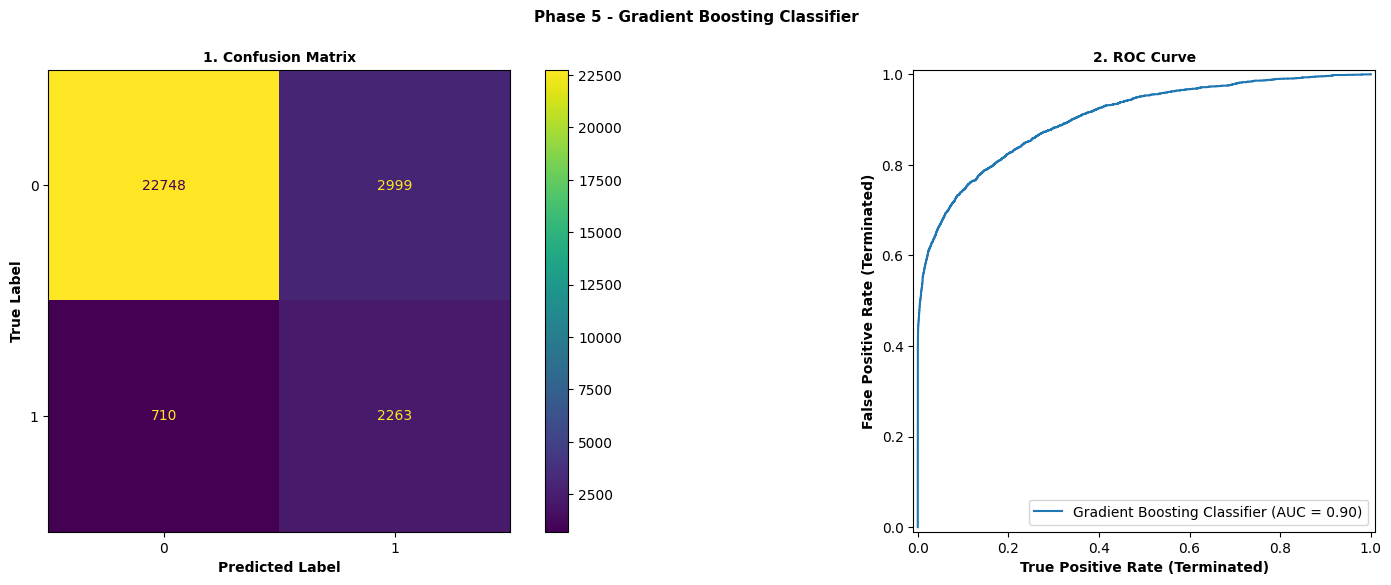

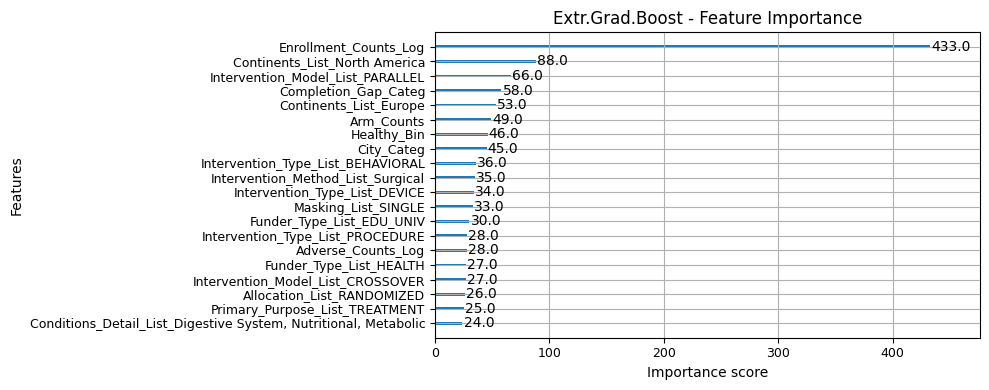

In [346]:
# Model
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric = 'logloss',  # avoids warning
    random_state = 42)

# CV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]}

xgb_grid = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1, verbose = 1)

# Final Model
xgb_model = xgb_grid.fit(X_train_xgb, y_train_xgb)
print("Best Parameters:", xgb_model.best_params_)
# print("Best Estimator:", xgb_model.best_estimator_) # too long output. 

# y_pred
y_pred_xgb = xgb_model.predict(X_test_xgb)

# Accuracy Score
accuracy(dfi, i, xgb_model, X_test_xgb, y_test_xgb, y_pred_xgb, "Gradient Boosting Classifier")

# Plot Feature Importances
fig, ax = plt.subplots(figsize = (10, 4), squeeze = True)
plot_importance(xgb_model.best_estimator_ , max_num_features = 20, ax = ax)
plt.yticks(fontsize = 9)
plt.xticks(fontsize = 9)
plt.title("Extr.Grad.Boost - Feature Importance")
plt.tight_layout()
plt.show()


C:\Users\Eugenia\AppData\Local\Temp\ipykernel_27272\3948197801.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_xgb_sam, plot_size = (10, 5), show = False)


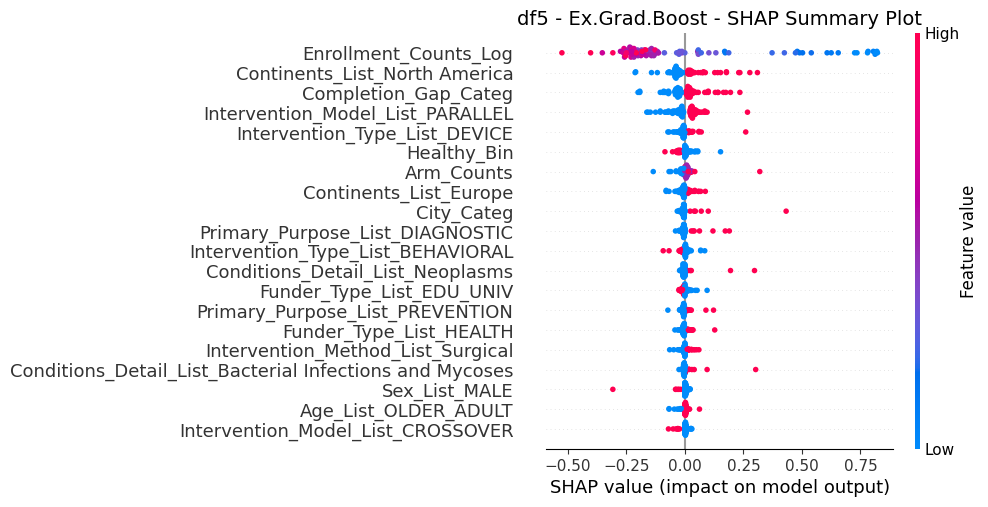

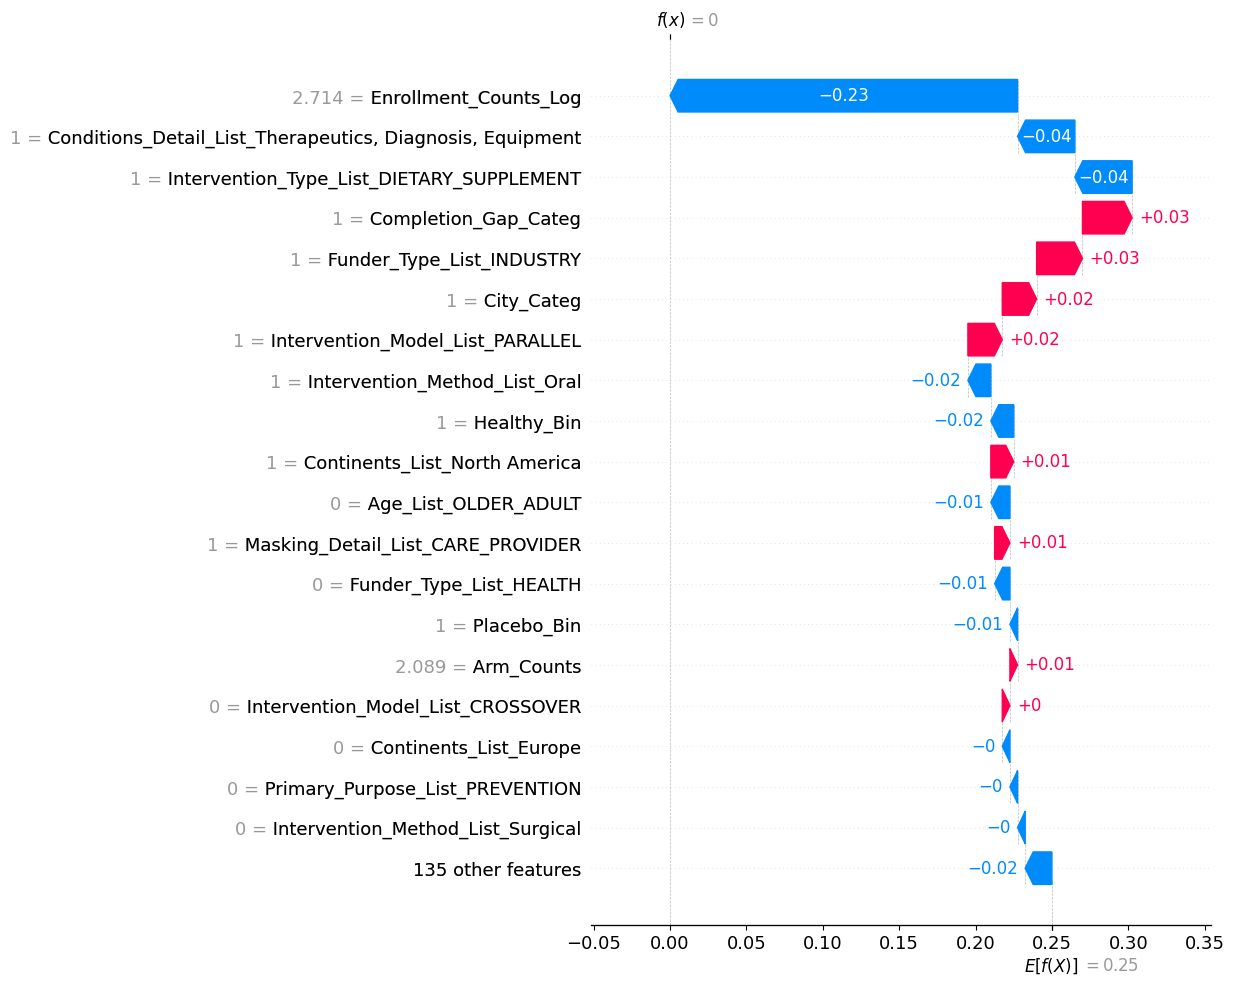

In [347]:
# SHAP
X_test_xgb_sam = shap.sample(X_test_xgb, 100)
explainer = shap.Explainer(xgb_model.best_estimator_.predict, X_test_xgb_sam)
shap_values = explainer(X_test_xgb_sam)

# Save plot
model = 'xgb_model'
folder_shap = "shap_plots"
os.makedirs(folder_shap, exist_ok=True)
filename = f"shap_{model}_df{i}.png"
filepath = os.path.join(folder_shap, filename)

# Summary Plot SHAP --> overall 
shap.summary_plot(shap_values, X_test_xgb_sam, plot_size = (10, 5), show = False)
plt.title(f"df{i} - Ex.Grad.Boost - SHAP Summary Plot", fontsize = 14)

fig = plt.gcf()
fig.savefig(filepath, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# Shap data point 
shap.waterfall_plot(shap_values[0], max_display=20)

# ROC Curve

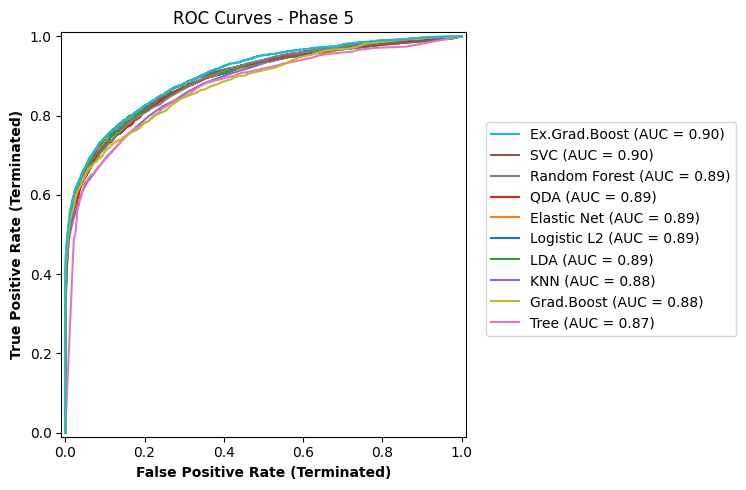

In [348]:
# Save Path
folder_roc = "roc_plots"
os.makedirs(folder_roc, exist_ok = True)
filename = f"roc_df{i}.png"
filepath = os.path.join(folder_roc, filename)

# Plot
models = [
    ("Logistic L2", log_model, X_test_log, y_test_log),
    ("Elastic Net", el_model, X_test_el, y_test_el),
    ("LDA", lda_model, X_test_lda, y_test_lda),
    ("QDA", qda_model, X_test_qda, y_test_qda),
    ("KNN", knn_model, X_test_knn, y_test_knn),
    ("SVC", svc_model, X_test_svc, y_test_svc),
    ("Tree", tr_model, X_test_tr, y_test_tr),
    ("Random Forest", rf_model, X_test_rf, y_test_rf),
    ("Grad.Boost", gb_model, X_test_gb, y_test_gb),
    ("Ex.Grad.Boost", xgb_model, X_test_xgb, y_test_xgb)
]

fig = plt.figure(figsize=(10, 5))
ax = plt.gca()

aucs = []
for original_name, model, X_test_model, y_test_model in models:
    y_score = model.predict_proba(X_test_model)[:, 1] #\
        # if hasattr(model, "predict_proba") \
        # else model.decision_function(X_test_model) # if model does not support probability (SVC model --> setted as probability = True)

    auc = roc_auc_score(y_test_model, y_score)
    label = f"{original_name} (AUC = {auc:.2f})"
    roc = RocCurveDisplay.from_estimator(
        model,
        X_test_model,
        y_test_model,
        ax=ax,
        name=label,
        pos_label=1  # Completed = 0, Terminated = 1
    )
    aucs.append((auc, label, roc.line_))

aucs.sort(key=lambda x: x[0], reverse=True)
sorted_handles = [item[2] for item in aucs]
sorted_labels = [item[1] for item in aucs]

ax.legend(sorted_handles, sorted_labels, loc=[1.05, 0.25])
ax.set_xlabel("False Positive Rate (Terminated)", fontsize = 10, fontweight = 'bold')
ax.set_ylabel("True Positive Rate (Terminated)", fontsize = 10, fontweight = 'bold')
plt.title(f"ROC Curves - Phase {i}")
plt.tight_layout()

# Save Plot
plt.savefig(filepath, dpi = 100, bbox_inches = 'tight')
plt.show()
plt.close()